In [ ]:
#!pip install xgboost


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.8 kB 640.0 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7/60.8 kB 325.1 kB/s eta 0:00:01
     ------------------- ------------------ 30.7

In [95]:
# Importing necessary libraries
import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
import missingno as msno
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import accuracy_score, log_loss, cohen_kappa_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [3]:
train_data = pd.read_csv('data/Training.csv')

test_data = pd.read_csv('data/Testing.csv')

train_data.head(10) # looking at the first few rows of data 
total_columns = len(train_data.columns)
total_rows = len(train_data['prognosis'])
prognoses = train_data['prognosis'].unique().tolist()

print(f"The training dataset has a total of {total_rows} rows and {total_columns} columns. This means that there are {total_columns - 1} predictor variables. \nwithin the prognosis column, there are {len(prognoses)} diseases included.")

The training dataset has a total of 4920 rows and 134 columns. This means that there are 133 predictor variables. 
within the prognosis column, there are 41 diseases included.


In [4]:
train_data.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis',
       'Unnamed: 133'],
      dtype='object', length=134)

In [5]:
test_data.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis'],
      dtype='object', length=133)

In [4]:
# Looking at the distribution of the prognoses within the dataset - determining if there is an imbalance 
100 * train_data.groupby('prognosis').size()/train_data.shape[0] # seems like everything is evenly balanced 

train_data['prognosis'] = train_data['prognosis'].str.title() # Making things look nicer for plotting 

In [5]:
value_columns = train_data.columns.difference(['prognosis', 'Unnamed: 133']).tolist()

# repeat this process for every disease basically


melted_train_data = train_data.melt(id_vars=['prognosis'], value_vars=value_columns).groupby(['prognosis', 'variable']).sum('value')

melted_train_data = melted_train_data[melted_train_data['value'] > 0]


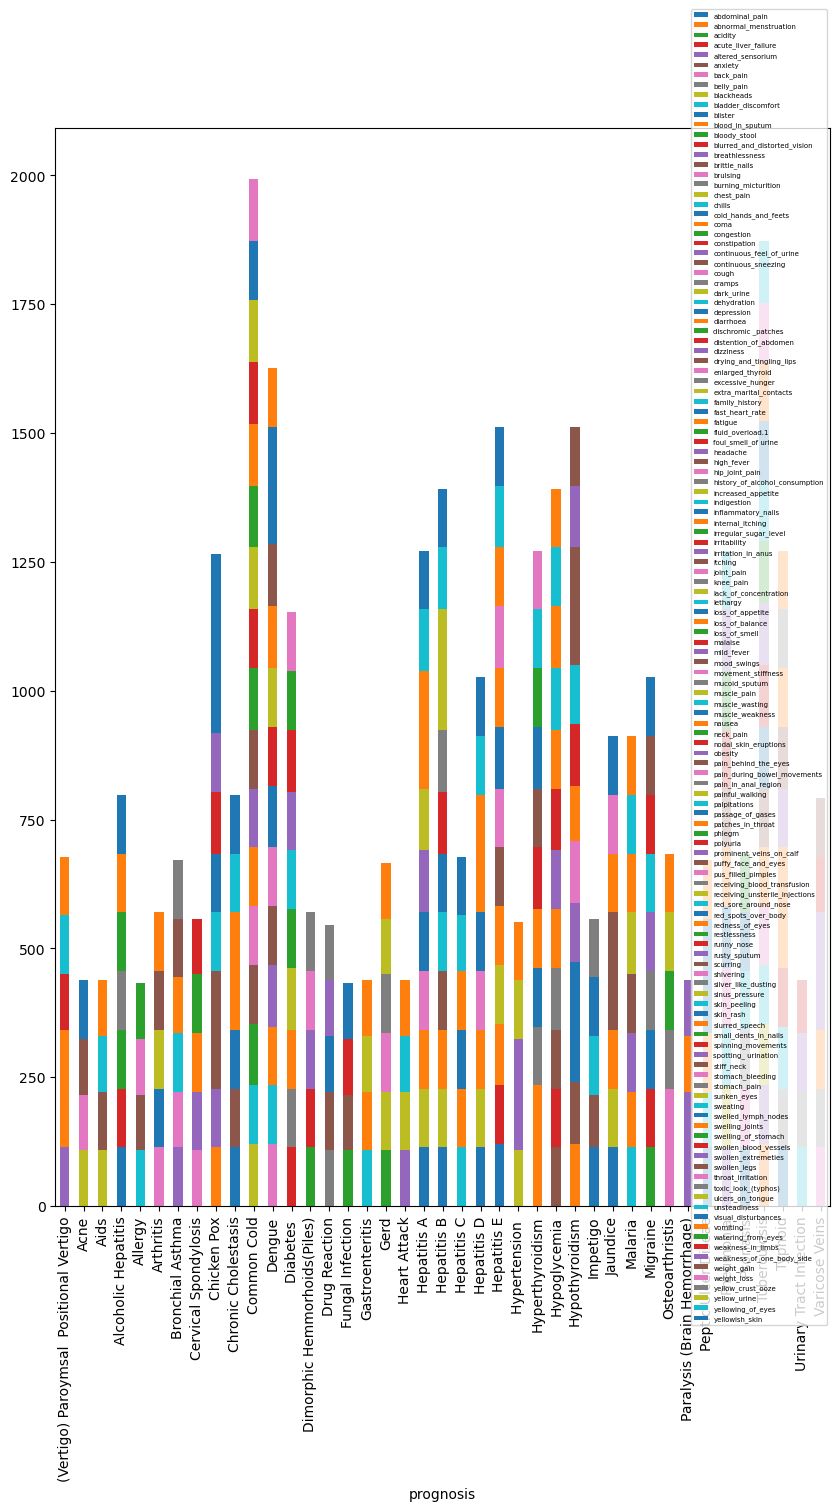

In [8]:
melted_train_data = train_data.melt(id_vars=['prognosis'], value_vars=value_columns)

melted_train_data = melted_train_data[melted_train_data['value'] > 0]
ax = melted_train_data.groupby(['prognosis', 'variable'])['value'].sum().unstack().plot(kind='bar', stacked=True, figsize=[10,14])
ax.legend(loc='right', fontsize=5)


                       itching  skin_rash  nodal_skin_eruptions  \
itching               1.000000   0.318158              0.326439   
skin_rash             0.318158   1.000000              0.298143   
nodal_skin_eruptions  0.326439   0.298143              1.000000   
continuous_sneezing  -0.086906  -0.094786             -0.032566   
shivering            -0.059893  -0.065324             -0.022444   
...                        ...        ...                   ...   
inflammatory_nails   -0.061573   0.331087             -0.023073   
blister              -0.061573   0.331087             -0.023073   
red_sore_around_nose -0.061573   0.331087             -0.023073   
yellow_crust_ooze    -0.061573   0.331087             -0.023073   
Unnamed: 133               NaN        NaN                   NaN   

                      continuous_sneezing  shivering    chills  joint_pain  \
itching                         -0.086906  -0.059893 -0.175905   -0.160650   
skin_rash                       -0.0947

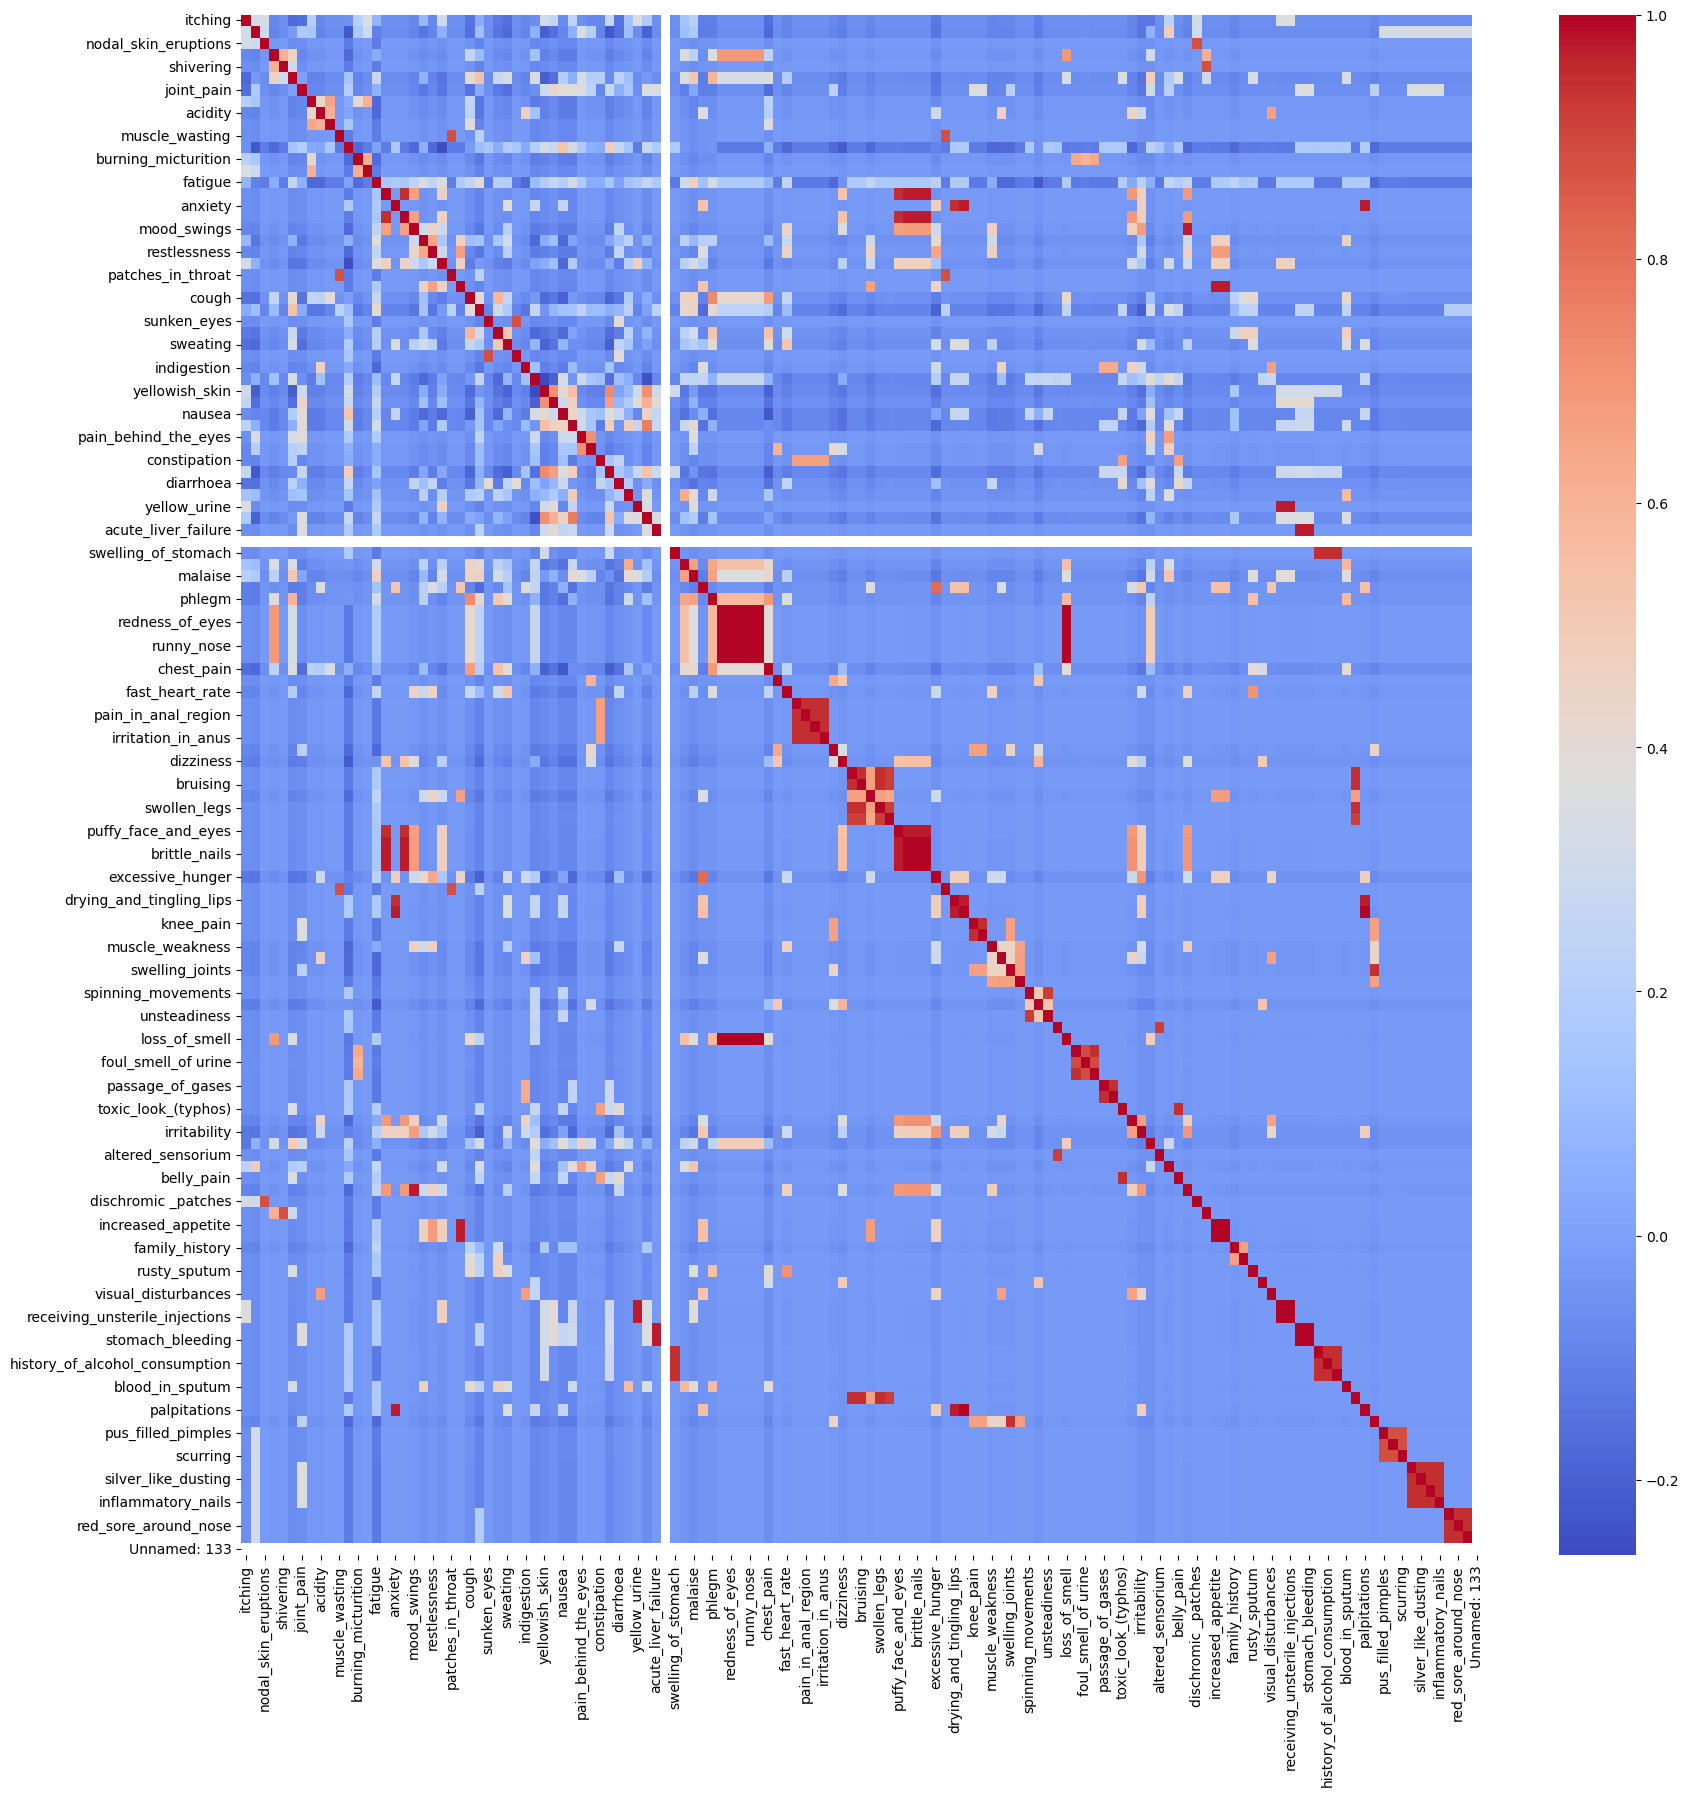

In [7]:
# Next the concept is to create a correlation matrix between the variables 
print(train_data.corr(numeric_only=True))
plt.figure(figsize=(20,20))
sns.set_context(rc={"figure.figsize": (20,20)})
heat_plot = sns.heatmap(train_data.corr(numeric_only=True), annot=False, cmap=sns.color_palette("coolwarm", as_cmap=True))

plt.show()

In [133]:
def load_and_examine_data(df):
    """
    Initial data examination
    """
    print("=== Basic Dataset Information ===")
    print(f"\nDataset contains {df.shape[0]} rows and {df.shape[1]} columns")
    print("\nFeature Names:", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    
    # Basic statistics for numerical columns
    print("\n=== Numerical Features Statistics ===")
    print(df.describe())
    
    return df



In [134]:
load_and_examine_data(train_data)

=== Basic Dataset Information ===

Dataset contains 4920 rows and 134 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4920 entries, 0 to 4919
Columns: 134 entries, itching to disease_encoded
dtypes: float64(1), int64(132), object(1)
memory usage: 5.0+ MB

Feature Names: ['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing', 'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity', 'ulcers_on_tongue', 'muscle_wasting', 'vomiting', 'burning_micturition', 'spotting_ urination', 'fatigue', 'weight_gain', 'anxiety', 'cold_hands_and_feets', 'mood_swings', 'weight_loss', 'restlessness', 'lethargy', 'patches_in_throat', 'irregular_sugar_level', 'cough', 'high_fever', 'sunken_eyes', 'breathlessness', 'sweating', 'dehydration', 'indigestion', 'headache', 'yellowish_skin', 'dark_urine', 'nausea', 'loss_of_appetite', 'pain_behind_the_eyes', 'back_pain', 'constipation', 'abdominal_pain', 'diarrhoea', 'mild_fever', 'yellow_urine', 'yellowing_of_eyes', 'acute_liver_fa

,itching,skin_rash,nodal_skin_eruptions,continuous_sneezing,shivering,chills,joint_pain,stomach_pain,acidity,ulcers_on_tongue,...,scurring,skin_peeling,silver_like_dusting,small_dents_in_nails,inflammatory_nails,blister,red_sore_around_nose,yellow_crust_ooze,prognosis,disease_encoded
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,15.0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,15.0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,15.0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,15.0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Fungal infection,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,(vertigo) Paroymsal Positional Vertigo,0.0
4916,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,Acne,2.0
4917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Urinary tract infection,38.0
4918,0,1,0,0,0,0,1,0,0,0,...,0,1,1,1,1,0,0,0,Psoriasis,35.0


In [64]:

print("\nFirst 5 Rows of Data:")
print(train_data.head())


First 5 Rows of Data:
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  scurring  \
0       0           0             0        0                 0  ...         0   
1       0           0             0        0                 0  ...         0   
2       0           0             0        0                 0  ...         0   
3       0           0             0        0                 0  ...         0   
4       0           0             0        0                 0  ...         0   

   skin_peeling

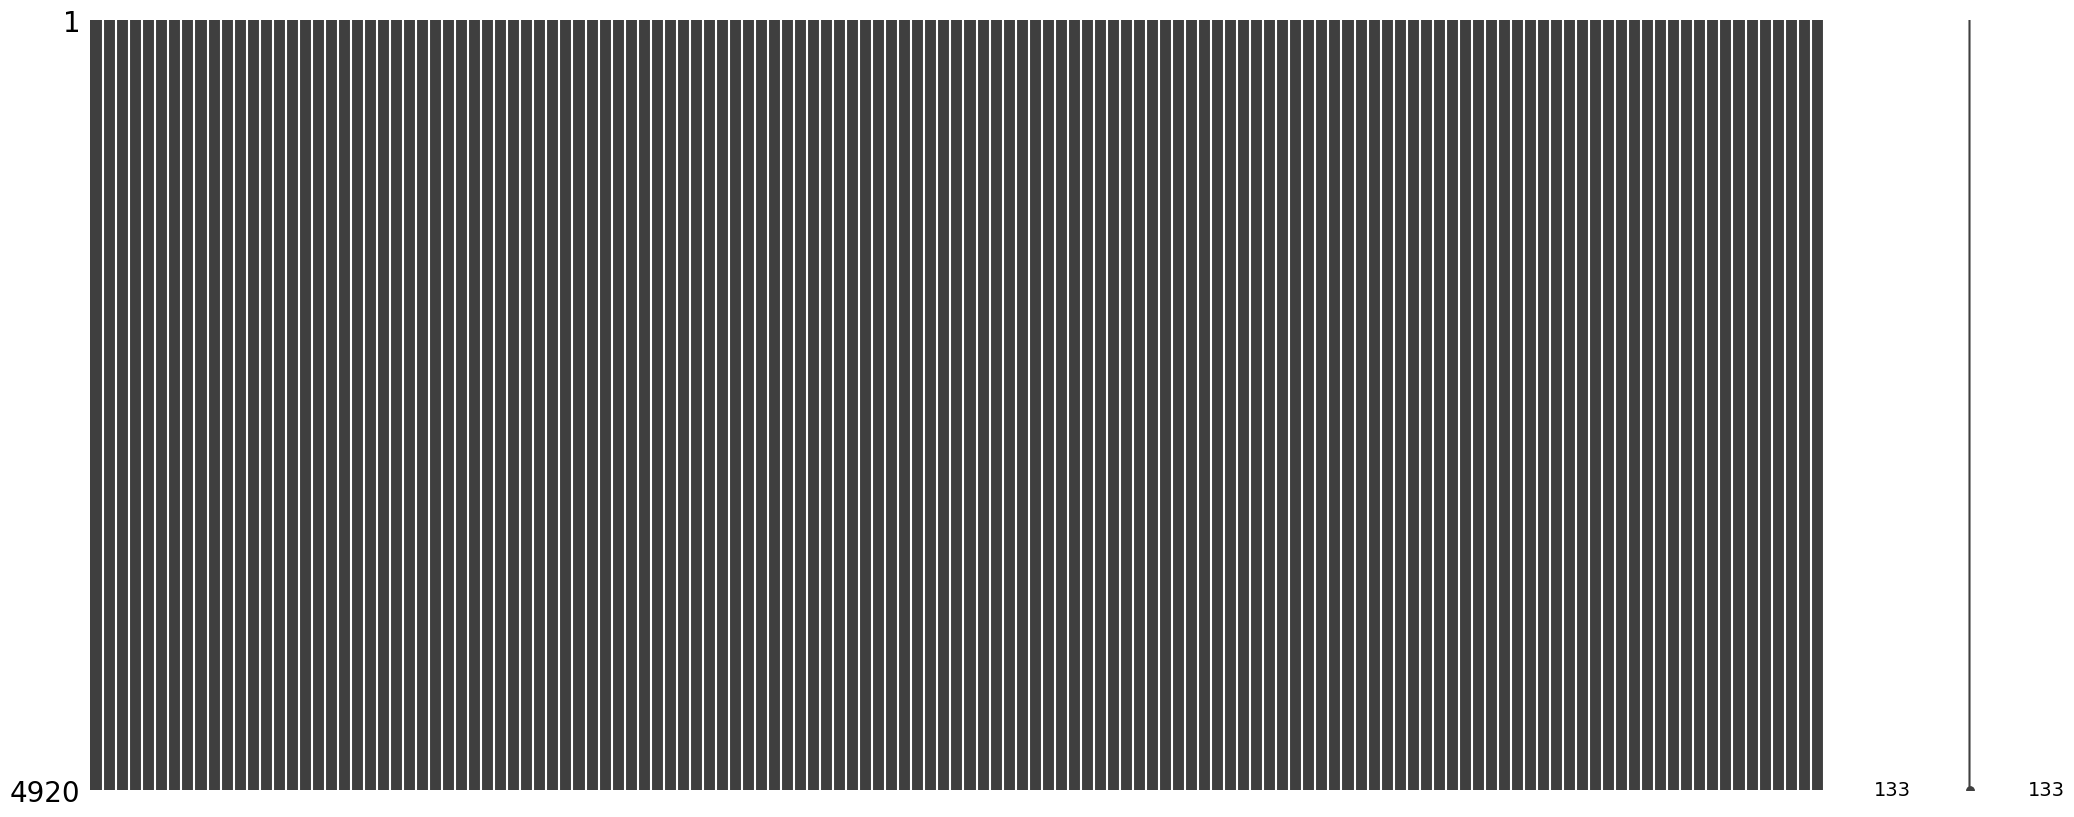

In [67]:

# Visualize missing values
msno.matrix(train_data)
plt.show()

In [136]:

# 2. Handle Missing Data
# Checking percentage of missing values
missing_percentage = train_data.isnull().mean() * 100
print("\nColumns with missing data > 0%:")
print(missing_percentage[missing_percentage > 0].sort_values(ascending=False))


Columns with missing data > 0%:
Series([], dtype: float64)


In [138]:

# drop column with no value
train_data = train_data.drop('Unnamed: 133', axis=1)

In [139]:

# 3. Statistical Summary
print("\nStatistical Summary:")
print(train_data.describe(include='all'))


Statistical Summary:
            itching    skin_rash  nodal_skin_eruptions  continuous_sneezing  \
count   4920.000000  4920.000000           4920.000000          4920.000000   
unique          NaN          NaN                   NaN                  NaN   
top             NaN          NaN                   NaN                  NaN   
freq            NaN          NaN                   NaN                  NaN   
mean       0.137805     0.159756              0.021951             0.045122   
std        0.344730     0.366417              0.146539             0.207593   
min        0.000000     0.000000              0.000000             0.000000   
25%        0.000000     0.000000              0.000000             0.000000   
50%        0.000000     0.000000              0.000000             0.000000   
75%        0.000000     0.000000              0.000000             0.000000   
max        1.000000     1.000000              1.000000             1.000000   

          shivering       chi

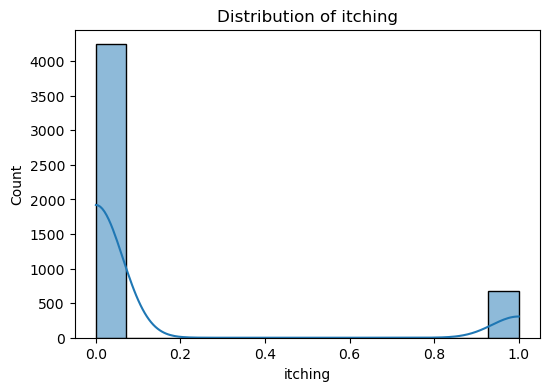

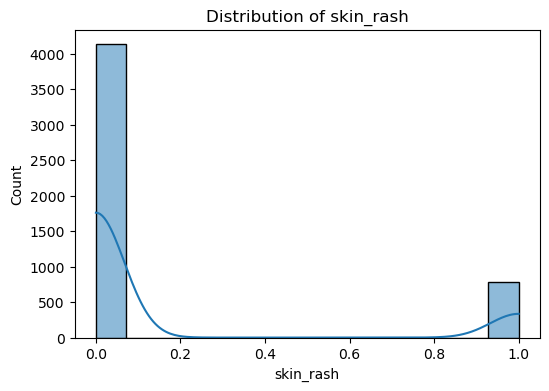

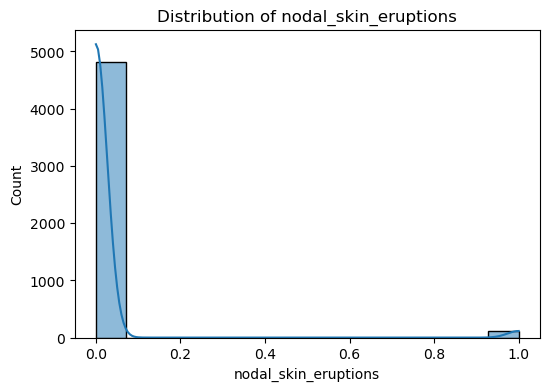

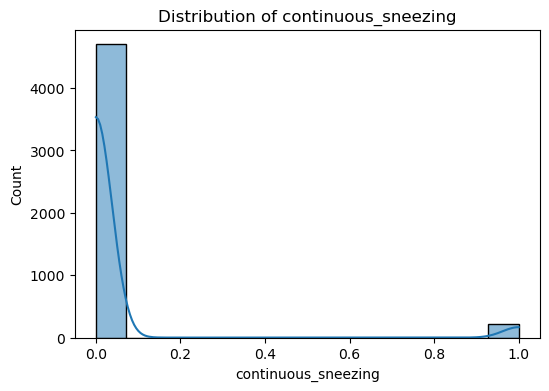

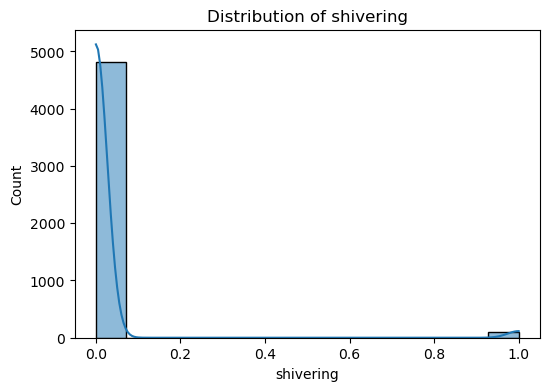

In [71]:

# 4. Distribution of Symptoms (features)
# Visualize distribution of a few sample symptoms
sample_symptoms = train_data.columns[:5]  # Take a few random symptoms
for symptom in sample_symptoms:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_data[symptom].dropna(), kde=True)
    plt.title(f"Distribution of {symptom}")
    plt.show()

In [72]:

# 5. Disease Prognosis Analysis
# Target variable: prognosis
print("\nUnique Diseases in Target Column:")
print(train_data['prognosis'].unique())


Unique Diseases in Target Column:
['Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction'
 'Peptic ulcer diseae' 'AIDS' 'Diabetes ' 'Gastroenteritis'
 'Bronchial Asthma' 'Hypertension ' 'Migraine' 'Cervical spondylosis'
 'Paralysis (brain hemorrhage)' 'Jaundice' 'Malaria' 'Chicken pox'
 'Dengue' 'Typhoid' 'hepatitis A' 'Hepatitis B' 'Hepatitis C'
 'Hepatitis D' 'Hepatitis E' 'Alcoholic hepatitis' 'Tuberculosis'
 'Common Cold' 'Pneumonia' 'Dimorphic hemmorhoids(piles)' 'Heart attack'
 'Varicose veins' 'Hypothyroidism' 'Hyperthyroidism' 'Hypoglycemia'
 'Osteoarthristis' 'Arthritis' '(vertigo) Paroymsal  Positional Vertigo'
 'Acne' 'Urinary tract infection' 'Psoriasis' 'Impetigo']


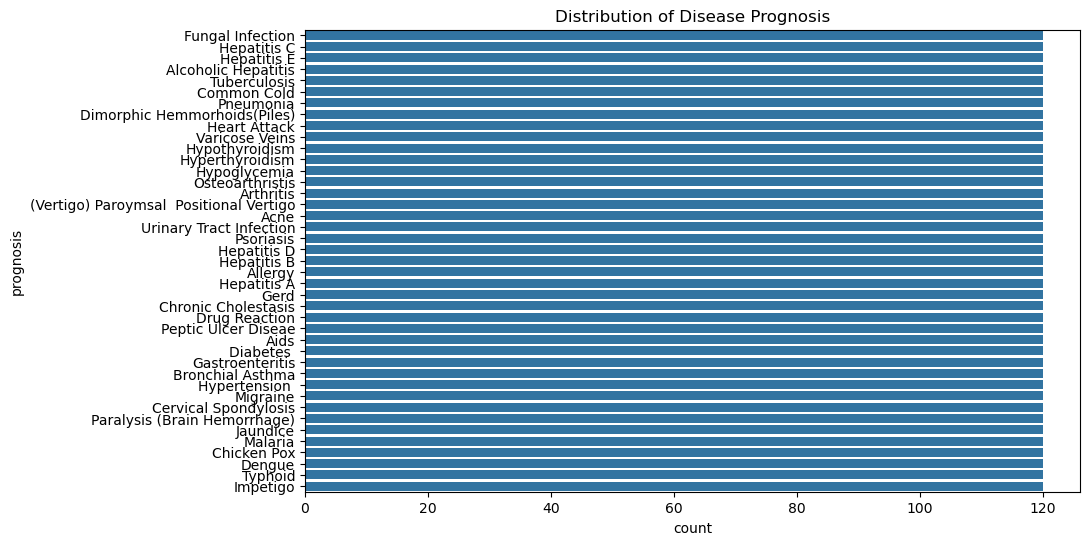

In [37]:
# Distribution of target labels (diseases)
plt.figure(figsize=(10, 6))
sns.countplot(y=train_data['prognosis'], order=train_data['prognosis'].value_counts().index)
plt.title('Distribution of Disease Prognosis')
plt.show()

In [39]:

# Checking imbalance in prognosis classes
prognosis_counts = train_data['prognosis'].value_counts()
print("\nDistribution of diseases:")
print(prognosis_counts)


Distribution of diseases:
prognosis
Fungal Infection                           120
Hepatitis C                                120
Hepatitis E                                120
Alcoholic Hepatitis                        120
Tuberculosis                               120
Common Cold                                120
Pneumonia                                  120
Dimorphic Hemmorhoids(Piles)               120
Heart Attack                               120
Varicose Veins                             120
Hypothyroidism                             120
Hyperthyroidism                            120
Hypoglycemia                               120
Osteoarthristis                            120
Arthritis                                  120
(Vertigo) Paroymsal  Positional Vertigo    120
Acne                                       120
Urinary Tract Infection                    120
Psoriasis                                  120
Hepatitis D                                120
Hepatitis B            

In [73]:

# 6. Correlation Analysis
# Encode the categorical target for correlation analysis
le = LabelEncoder()
train_data['disease_encoded'] = le.fit_transform(train_data['prognosis'])

In [76]:
train_data['disease_encoded'].unique()

array([15,  4, 16,  9, 14, 33,  1, 12, 17,  6, 23, 30,  7, 32, 28, 29,  8,
       11, 37, 40, 19, 20, 21, 22,  3, 36, 10, 34, 13, 18, 39, 26, 24, 25,
       31,  5,  0,  2, 38, 35, 27])

In [97]:
train_data['disease_encoded'] = train_data['disease_encoded'].astype(float)

In [98]:
train_data.columns

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'prognosis',
       'disease_encoded'],
      dtype='object', length=134)

In [99]:
train_data['disease_encoded'].dtype

dtype('float64')

In [101]:
# Select only numeric columns for correlation matrix
numeric_data = train_data.select_dtypes(include=['float64', 'int64'])

In [102]:
numeric_data.columns.to_list

<bound method IndexOpsMixin.tolist of Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'disease_encoded'],
      dtype='object', length=133)>

In [103]:

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

In [104]:
print(corr_matrix.columns)

Index(['itching', 'skin_rash', 'nodal_skin_eruptions', 'continuous_sneezing',
       'shivering', 'chills', 'joint_pain', 'stomach_pain', 'acidity',
       'ulcers_on_tongue',
       ...
       'blackheads', 'scurring', 'skin_peeling', 'silver_like_dusting',
       'small_dents_in_nails', 'inflammatory_nails', 'blister',
       'red_sore_around_nose', 'yellow_crust_ooze', 'disease_encoded'],
      dtype='object', length=133)


In [81]:
# Correlation matrix
#corr_matrix = train_data.corr()


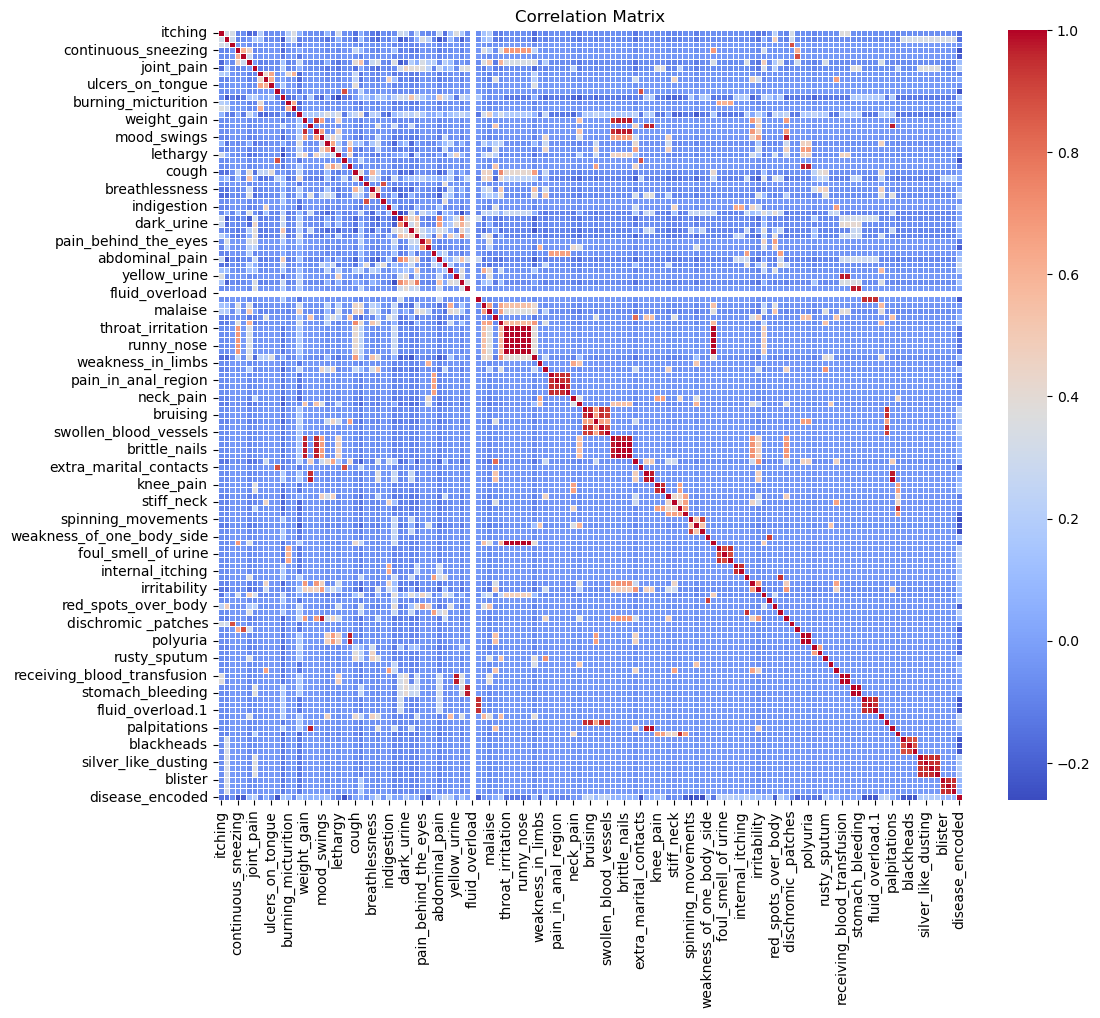

In [106]:

# Visualize correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [108]:
# 7. Explore Relationships between Symptoms and Disease
# Analyze correlation between symptoms and disease prognosis
# This might be done using one-hot encoding or label encoding if symptoms are categorical


# Correlation of all features with the target column (disease)
correlations = corr_matrix['disease_encoded'].sort_values(ascending=False)
print("\nCorrelation between Symptoms and Disease:")
print(correlations)


Correlation between Symptoms and Disease:
disease_encoded            1.000000
diarrhoea                  0.285993
sweating                   0.261934
bruising                   0.247315
prominent_veins_on_calf    0.247315
                             ...   
patches_in_throat         -0.240568
muscle_wasting            -0.240568
spinning_movements        -0.253230
unsteadiness              -0.260331
fluid_overload                  NaN
Name: disease_encoded, Length: 133, dtype: float64


C:\Users\Tooman\AppData\Local\Temp\ipykernel_32684\2760805871.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=significant_correlations.values, y=significant_correlations.index, palette='viridis')


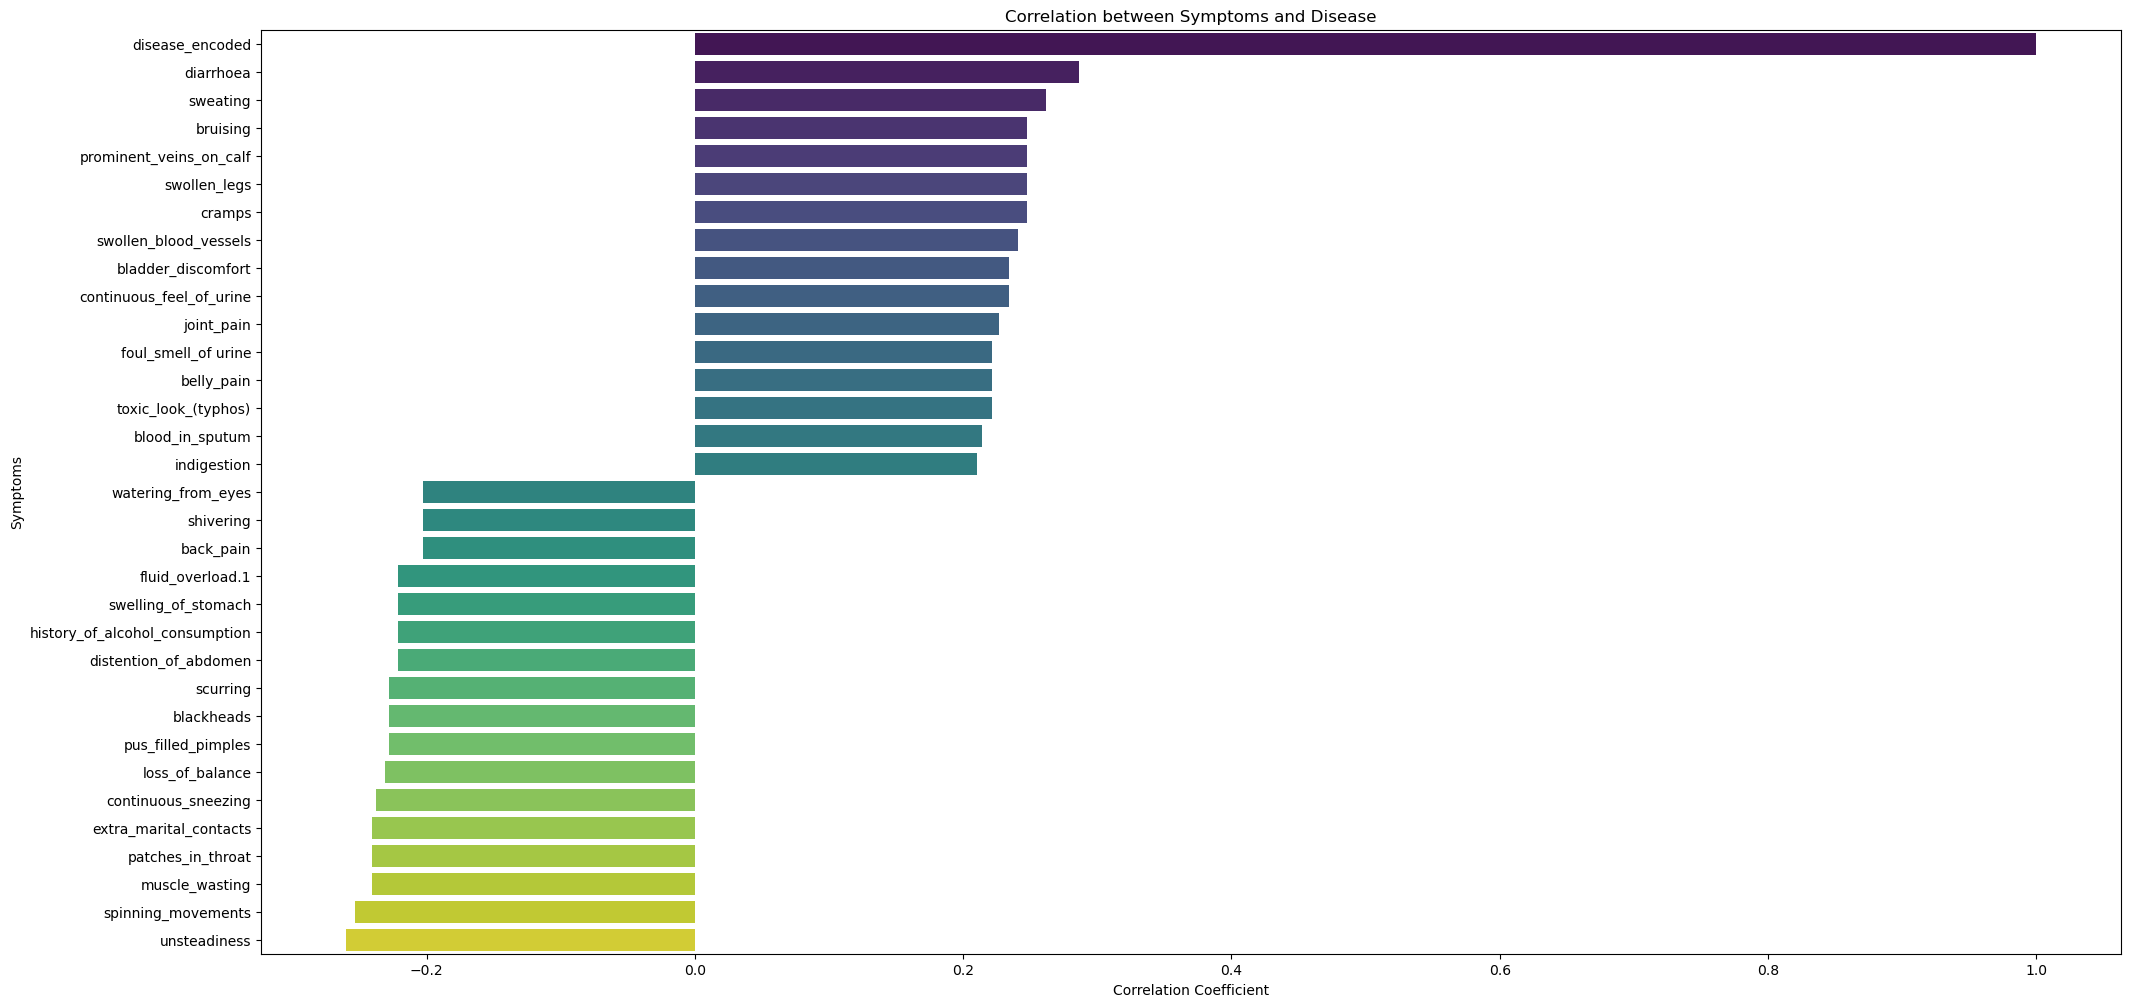

In [118]:
# Setting a threshold for correlation
threshold = 0.2

# Sorting correlations in descending order
correlations_sorted = correlations.sort_values(ascending=False)

# Filtering correlations above or below the threshold
significant_correlations = correlations_sorted[abs(correlations_sorted) > threshold]


# Plotting the bar chart
plt.figure(figsize=(24, 12))
sns.barplot(x=significant_correlations.values, y=significant_correlations.index, palette='viridis')
plt.title("Correlation between Symptoms and Disease")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Symptoms")
plt.show()


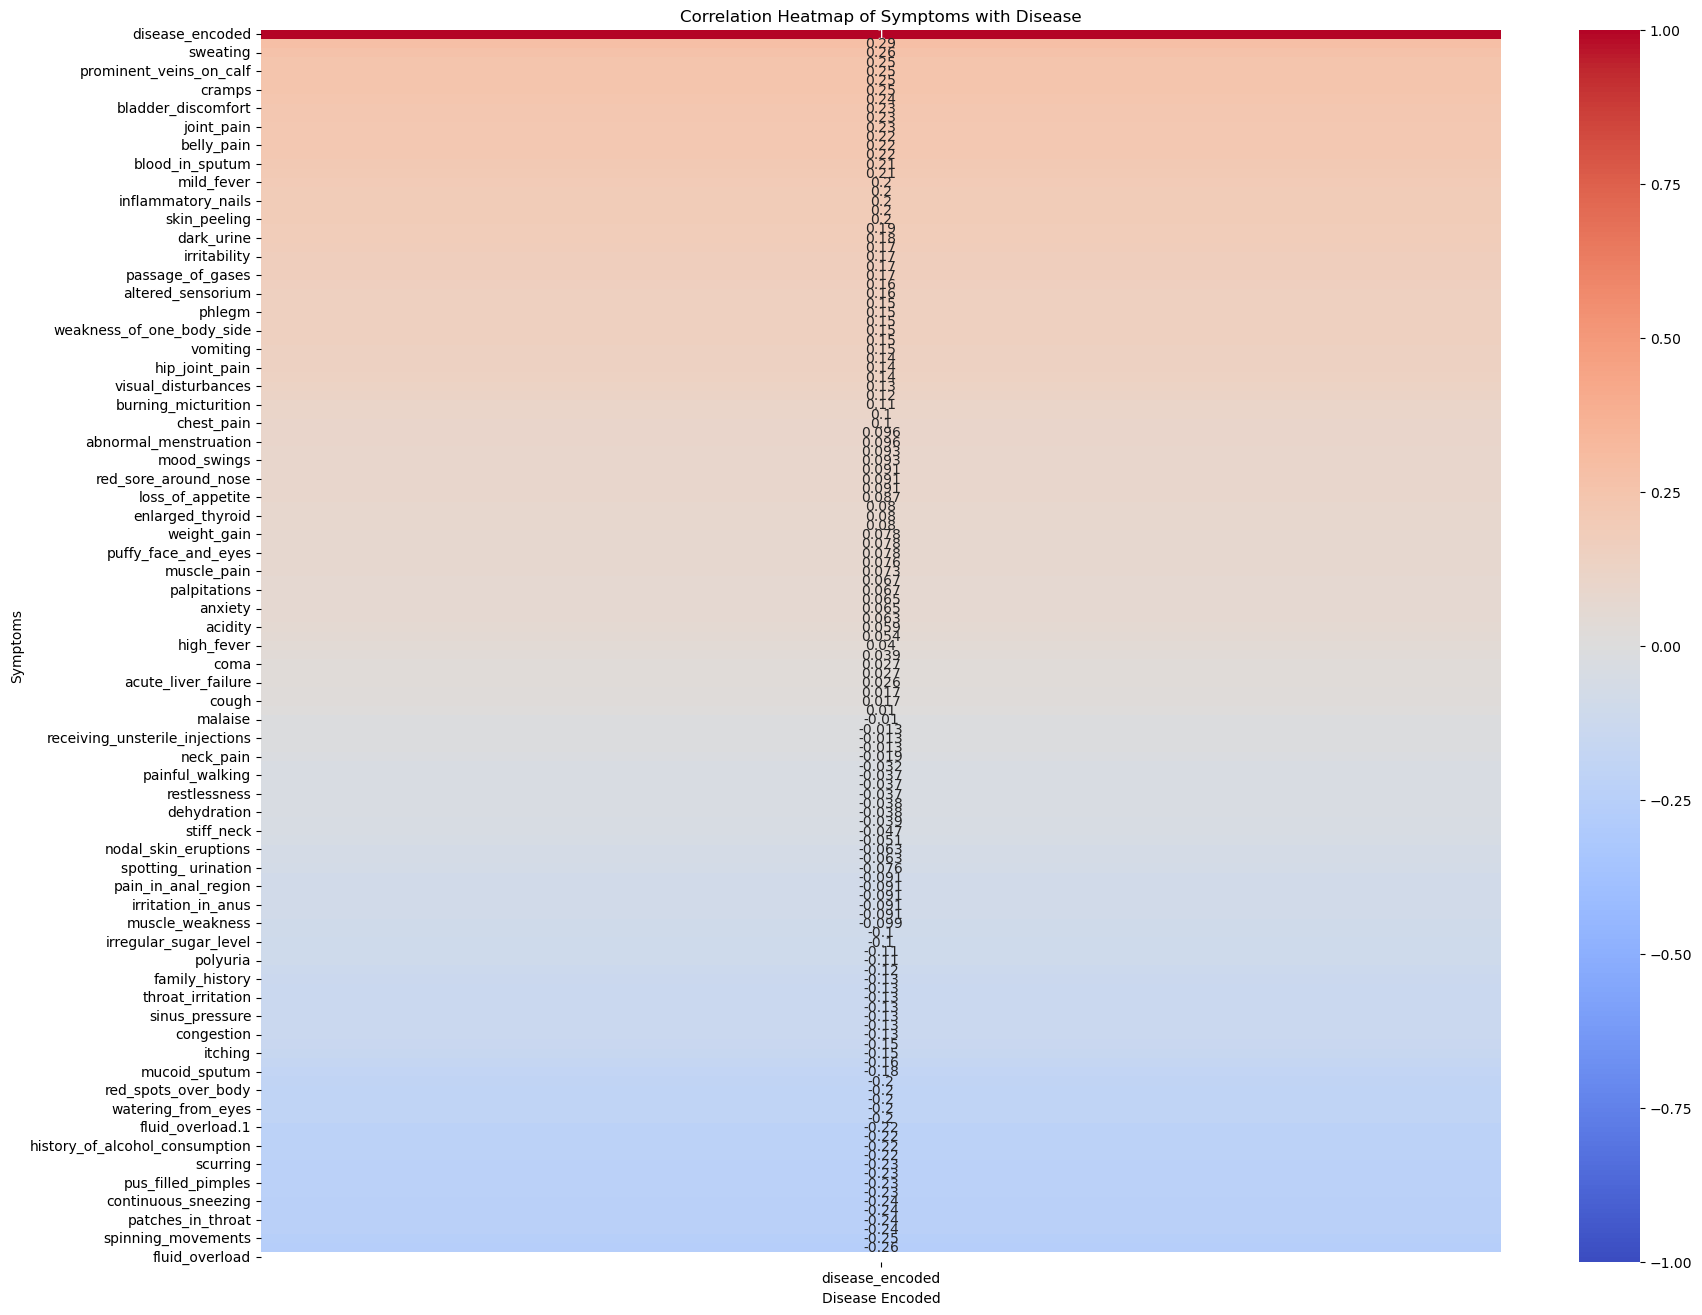

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix[['disease_encoded']].sort_values(by='disease_encoded', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Symptoms with Disease")
plt.xlabel("Disease Encoded")
plt.ylabel("Symptoms")
plt.show()


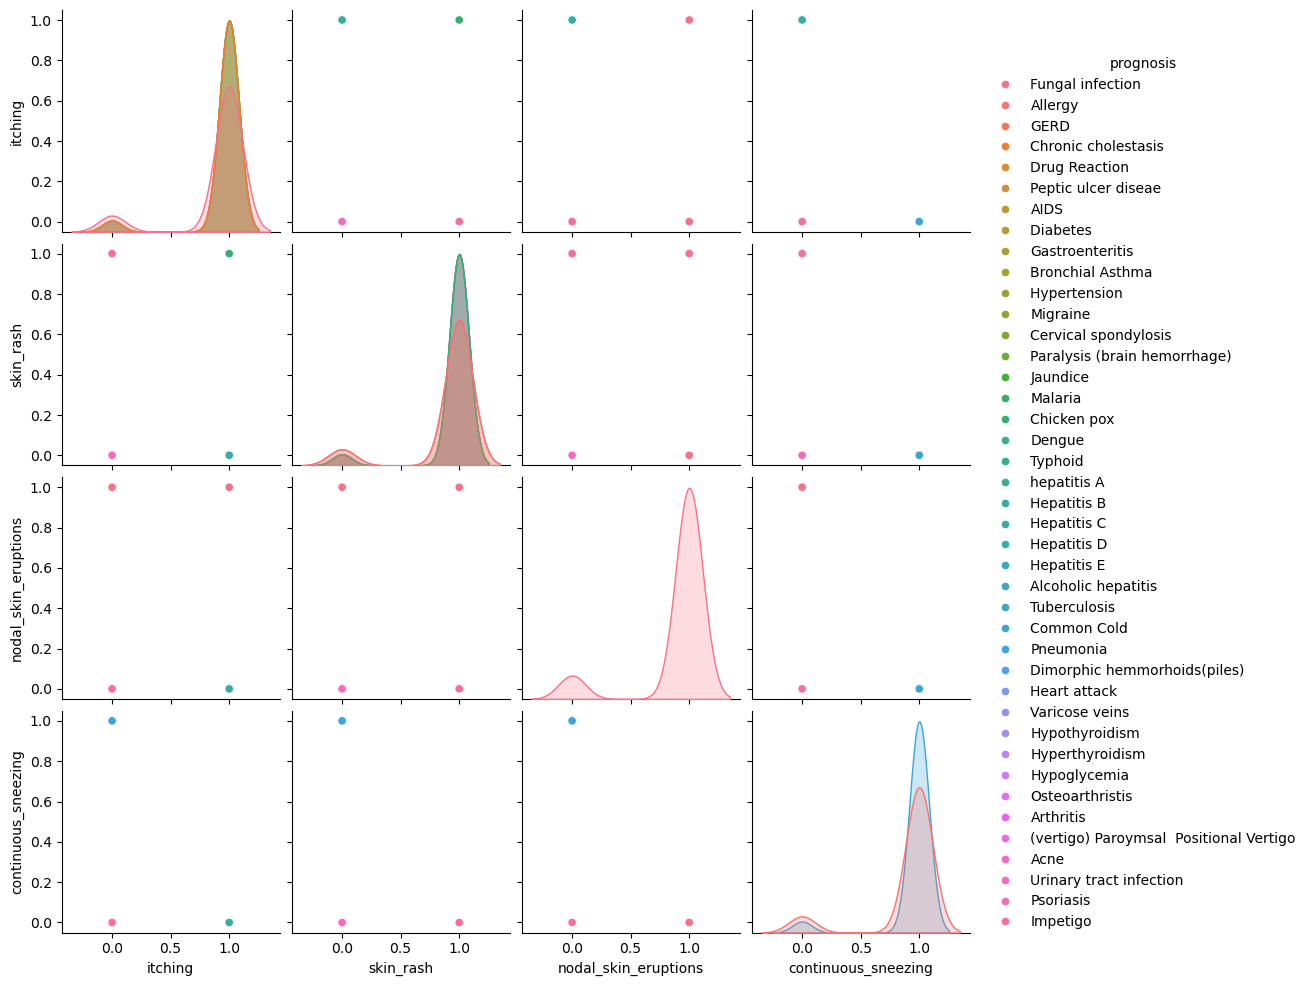

In [120]:
# Pairplot for certain symptoms (you can select important symptoms after correlation analysis)
sns.pairplot(train_data, vars=sample_symptoms[:4], hue="prognosis")
plt.show()


#### Loading and Inspecting Data: Shows the basic structure, missing data, and a summary of your dataset.
<!-- 
Handling Missing Data: Visualizes and quantifies missing values.
Exploring Data Distribution: Visualizes the distribution of a few sample symptoms (you can extend this to all).
Correlation Analysis: Examines the relationships between symptoms and between symptoms and disease prognosis.
Target (Disease Prognosis) Analysis: Checks for class imbalance in the target variable (diseases) and visualizes it.
Random Forest Feature Importance: Uses a Random Forest model to get an idea of feature importance. -->

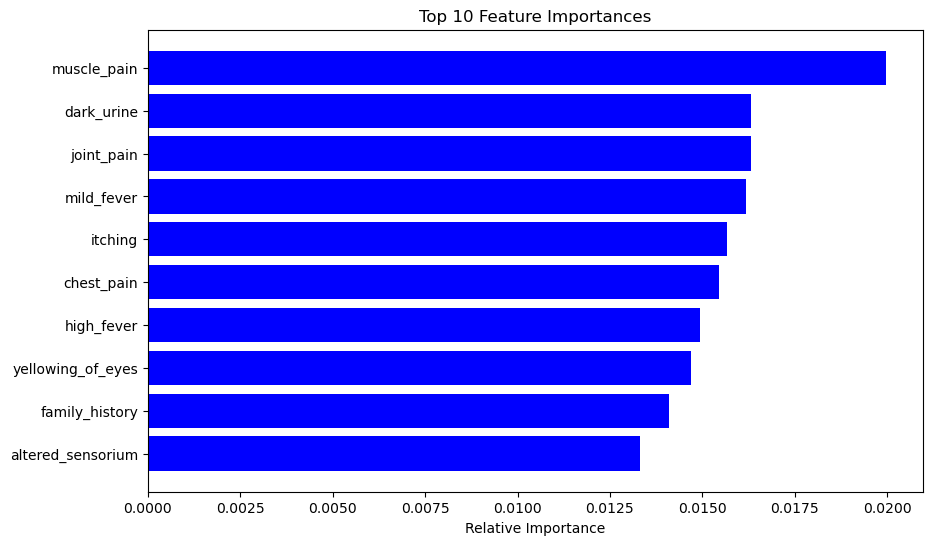

In [113]:

# 8. Feature Importance using Random Forest (Optional)
from sklearn.ensemble import RandomForestClassifier

# Let's assume symptoms are already encoded as 0/1 or numerical
X = train_data.drop(columns=['prognosis', 'disease_encoded'])
y = train_data['disease_encoded']

model = RandomForestClassifier()
model.fit(X, y)

# Feature Importance
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 important features

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


### Feature Engineering

PCA

Handle Missing Value

Label Encoding

LDA

Embeddings

Scaling / Normalization

## Modelling

In [ ]:
cat_cols = ['prognosis']

In [5]:
# drop column with no value
train_data = train_data.drop('Unnamed: 133', axis=1)

In [6]:
train_data.shape

(4920, 133)

In [54]:
pipeline_A = Pipeline([
    ('classifier', DecisionTreeClassifier())
])
pipeline_A

Pipeline(steps=[('classifier', DecisionTreeClassifier())])

In [55]:
pipeline_B = Pipeline([
    ('classifier', RandomForestClassifier())
])
pipeline_B

Pipeline(steps=[('classifier', RandomForestClassifier())])

In [56]:
pipeline_C = Pipeline([
    ('classifier', XGBClassifier())
])
pipeline_C

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [96]:
pipeline_D = Pipeline([
    ('classifier', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
])
pipeline_D

Pipeline(steps=[('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000)))])

In [106]:
pipeline_E = Pipeline([
    ('classifier', SVC())
])
pipeline_E

Pipeline(steps=[('classifier', SVC())])

In [113]:
X_train = train_data.drop(columns=['prognosis'])

Y_train = train_data['prognosis']

X_test = test_data.drop(columns=['prognosis'])

Y_test = test_data['prognosis']

scoring = ['neg_log_loss', 'roc_auc', 'f1', 'accuracy', 'precision', 'recall']

In [114]:
# Custom target transformer (Label Encoding for classification task)
class CustomTargetTransformer:
    def fit(self, y):
        # Fit the LabelEncoder to the target variable
        self.encoder = LabelEncoder()
        self.encoder.fit(y)
        return self

    def transform(self, y):
        # Transform the target variable to encoded values
        return self.encoder.transform(y)

    def inverse_transform(self, y):
        # Inverse transform to get the original target variable back
        return self.encoder.inverse_transform(y)
    

In [71]:
#Y_train = target_transformer.fit(Y_train)

Best for: When you want to treat all classes equally, regardless of their size.

Explanation: The macro average computes the metric (precision, recall, or F1) for each class independently, and then averages these scores. This is useful when the classes are of equal importance.

Use Case: If you want to ensure that your model performs equally well across all classes, without regard to class distribution, the macro average may be the best choice.
python


In [126]:
param_grid_A = {
    'classifier__max_depth': [10, 20, 30],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_search_A = GridSearchCV(
    pipeline_A,
    param_grid_A, cv=5,
    scoring= 'f1_weighted',
    refit= True
)

# Apply the transformation to the target variable (Y_train) outside of the pipeline
target_transformer = CustomTargetTransformer()
target_transformer.fit(Y_train)

# Fit the target transformer on Y_train and transform it
Y_train_transformed = target_transformer.transform(Y_train)

grid_search_A.fit(X_train, Y_train_transformed)
model_A_df = pd.DataFrame(grid_search_A.cv_results_)
model_A_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005862,0.001656,0.002946,0.000514,10,sqrt,"{'classifier__max_depth': 10, 'classifier__max...",0.319232,0.301373,0.386339,0.441057,0.294309,0.348462,0.056591,5
1,0.005609,0.001799,0.003165,0.000621,10,log2,"{'classifier__max_depth': 10, 'classifier__max...",0.338873,0.251005,0.312979,0.306685,0.294309,0.300770,0.028824,6
2,0.006717,0.000217,0.003028,0.000723,20,sqrt,"{'classifier__max_depth': 20, 'classifier__max...",0.617820,0.652577,0.674046,0.612626,0.527100,0.616834,0.050243,4
3,0.005328,0.000561,0.002577,0.000470,20,log2,"{'classifier__max_depth': 20, 'classifier__max...",0.560698,0.767630,0.810406,0.703252,0.760532,0.720504,0.086881,3
4,0.006493,0.000108,0.002888,0.000533,30,sqrt,"{'classifier__max_depth': 30, 'classifier__max...",0.857387,0.826782,0.940197,0.886179,0.939024,0.889914,0.044717,2
5,0.005876,0.000261,0.002407,0.000489,30,log2,"{'classifier__max_depth': 30, 'classifier__max...",0.886269,0.956148,0.921426,0.886179,0.886179,0.907240,0.028000,1


In [127]:
grid_search_A.best_params_

{'classifier__max_depth': 30, 'classifier__max_features': 'log2'}

In [128]:
grid_search_A.best_estimator_

Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(max_depth=30, max_features='log2'))])

In [120]:
param_grid_B = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__max_features': ['sqrt', 'log2']
}

grid_search_B = GridSearchCV(
    pipeline_B,
    param_grid_B, cv=5,
    scoring= 'f1_weighted',
    refit=True
)


# Apply the transformation to the target variable (Y_train) outside of the pipeline
target_transformer = CustomTargetTransformer()
target_transformer.fit(Y_train)

# Fit the target transformer on Y_train and transform it
Y_train_transformed = target_transformer.transform(Y_train)

grid_search_B.fit(X_train, Y_train_transformed)
model_B_df = pd.DataFrame(grid_search_B.cv_results_)
model_B_df




,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__max_features,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.118714,0.028879,0.006855,0.000452,10,sqrt,50,"{'classifier__max_depth': 10, 'classifier__max...",0.996939,0.997964,1.0,1.0,1.0,0.998981,0.00129,8
1,0.212520,0.014910,0.010677,0.001332,10,sqrt,100,"{'classifier__max_depth': 10, 'classifier__max...",1.000000,1.000000,1.0,1.0,1.0,1.000000,0.00000,1
2,0.088546,0.002603,0.006462,0.000563,10,log2,50,"{'classifier__max_depth': 10, 'classifier__max...",1.000000,1.000000,1.0,1.0,1.0,1.000000,0.00000,1
3,0.177693,0.008571,0.010816,0.001058,10,log2,100,"{'classifier__max_depth': 10, 'classifier__max...",1.000000,1.000000,1.0,1.0,1.0,1.000000,0.00000,1
4,0.131687,0.002151,0.007479,0.001068,20,sqrt,50,"{'classifier__max_depth': 20, 'classifier__max...",1.000000,1.000000,1.0,1.0,1.0,1.000000,0.00000,1
5,0.258522,0.016390,0.012587,0.001896,20,sqrt,100,"{'classifier__max_depth': 20, 'classifier__max...",1.000000,1.000000,1.0,1.0,1.0,1.000000,0.00000,1
6,0.105861,0.002762,0.007925,0.000817,20,log2,50,"{'classifier__max_depth': 20, 'classifier__max...",1.000000,1.000000,1.0,1.0,1.0,1.000000,0.00000,1
7,0.210667,0.007082,0.011541,0.000502,20,log2,100,"{'classifier__max_depth': 20, 'classifier__max...",1.000000,1.000000,1.0,1.0,1.0,1.000000,0.00000,1


In [129]:
grid_search_B.best_params_

{'classifier__max_depth': 10,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 100}

In [130]:
grid_search_B.best_estimator_

Pipeline(steps=[('classifier', RandomForestClassifier(max_depth=10))])

In [124]:
param_grid_C = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20],
    #'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    #'classifier__subsample': [0.5, 0.7, 1.0],
    #'classifier__colsample_bytree': [0.5, 0.7, 1.0]
}

grid_search_C = GridSearchCV(
    pipeline_C,
    param_grid_C, cv=5,
    scoring= 'f1_weighted',
    refit=True
)

grid_search_C.fit(X_train, Y_train_transformed)
model_C_df = pd.DataFrame(grid_search_C.cv_results_)
model_C_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__max_depth,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.589551,0.063343,0.018482,0.001310,10,50,"{'classifier__max_depth': 10, 'classifier__n_e...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
1,0.940447,0.136241,0.017233,0.000400,10,100,"{'classifier__max_depth': 10, 'classifier__n_e...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
2,1.746630,0.164599,0.066183,0.091211,10,200,"{'classifier__max_depth': 10, 'classifier__n_e...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
3,1.531071,1.960975,0.024066,0.010468,20,50,"{'classifier__max_depth': 20, 'classifier__n_e...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
4,0.896502,0.075453,0.017126,0.000493,20,100,"{'classifier__max_depth': 20, 'classifier__n_e...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
5,1.695398,0.289032,0.029272,0.020515,20,200,"{'classifier__max_depth': 20, 'classifier__n_e...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1


In [131]:
grid_search_C.best_params_

{'classifier__max_depth': 10, 'classifier__n_estimators': 50}

In [132]:
grid_search_C.best_estimator_

Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [146]:
param_grid_D = {
    #'classifier__n_estimators': [50, 100, 200, 500],
    #'classifier__max_depth': [None, 10, 20, 30],
    #'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    #'classifier__subsample': [0.5, 0.7, 1.0],
    #'classifier__colsample_bytree': [0.5, 0.7, 1.0],
    'classifier__estimator__solver': ['liblinear'],
    'classifier__estimator__penalty': ['l1', 'l2'],
    'classifier__estimator__C': [0.01, 0.1, 1]
}

grid_search_D = GridSearchCV(
    pipeline_D,
    param_grid_D, cv=5,
    scoring= {'f1_macro': 'f1_macro', 'roc_auc_ovr': 'roc_auc_ovr'},
    refit='roc_auc_ovr'
)

grid_search_D.fit(X_train, Y_train_transformed)
model_D_df = pd.DataFrame(grid_search_D.cv_results_)
model_D_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__estimator__C,param_classifier__estimator__penalty,param_classifier__estimator__solver,params,split0_test_f1_macro,split1_test_f1_macro,...,std_test_f1_macro,rank_test_f1_macro,split0_test_roc_auc_ovr,split1_test_roc_auc_ovr,split2_test_roc_auc_ovr,split3_test_roc_auc_ovr,split4_test_roc_auc_ovr,mean_test_roc_auc_ovr,std_test_roc_auc_ovr,rank_test_roc_auc_ovr
0,0.308957,0.005259,0.120382,0.004470,0.01,l1,liblinear,"{'classifier__estimator__C': 0.01, 'classifier...",0.001161,0.001161,...,0.000000,6,0.5,0.50000,0.5,0.5,0.5,0.500000,0.000000,6
1,0.331400,0.027842,0.124925,0.007316,0.01,l2,liblinear,"{'classifier__estimator__C': 0.01, 'classifier...",1.000000,1.000000,...,0.000000,1,1.0,1.00000,1.0,1.0,1.0,1.000000,0.000000,1
2,0.359789,0.009049,0.123770,0.007155,0.10,l1,liblinear,"{'classifier__estimator__C': 0.1, 'classifier_...",0.995928,0.993879,...,0.002448,5,1.0,0.99999,1.0,1.0,1.0,0.999998,0.000004,5
3,0.360371,0.022739,0.125367,0.009153,0.10,l2,liblinear,"{'classifier__estimator__C': 0.1, 'classifier_...",1.000000,1.000000,...,0.000000,1,1.0,1.00000,1.0,1.0,1.0,1.000000,0.000000,1
4,0.407584,0.008486,0.136331,0.018753,1.00,l1,liblinear,"{'classifier__estimator__C': 1, 'classifier__e...",1.000000,1.000000,...,0.000000,1,1.0,1.00000,1.0,1.0,1.0,1.000000,0.000000,1
5,0.374574,0.020045,0.121116,0.003241,1.00,l2,liblinear,"{'classifier__estimator__C': 1, 'classifier__e...",1.000000,1.000000,...,0.000000,1,1.0,1.00000,1.0,1.0,1.0,1.000000,0.000000,1


In [148]:
grid_search_D.best_params_

{'classifier__estimator__C': 0.01,
 'classifier__estimator__penalty': 'l2',
 'classifier__estimator__solver': 'liblinear'}

In [149]:
grid_search_D.best_estimator_

Pipeline(steps=[('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.01,
                                                                  max_iter=1000,
                                                                  solver='liblinear')))])

In [138]:
param_grid_E = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': ['scale', 'auto']
}

grid_search_E = GridSearchCV(
    pipeline_E,
    param_grid_E, cv=5,
    scoring= 'f1_weighted',
    refit=True
)

grid_search_E.fit(X_train, Y_train_transformed)
model_E_df = pd.DataFrame(grid_search_E.cv_results_)
model_E_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__gamma,param_classifier__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.086674,0.005236,0.032306,0.010180,0.1,scale,linear,"{'classifier__C': 0.1, 'classifier__gamma': 's...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
1,0.266758,0.010070,0.162762,0.006973,0.1,scale,rbf,"{'classifier__C': 0.1, 'classifier__gamma': 's...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
2,0.099900,0.011951,0.032675,0.007345,0.1,auto,linear,"{'classifier__C': 0.1, 'classifier__gamma': 'a...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
3,0.986336,0.052520,0.467334,0.023707,0.1,auto,rbf,"{'classifier__C': 0.1, 'classifier__gamma': 'a...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
4,0.077804,0.003007,0.015799,0.000484,1.0,scale,linear,"{'classifier__C': 1, 'classifier__gamma': 'sca...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
5,0.114598,0.013394,0.048740,0.013508,1.0,scale,rbf,"{'classifier__C': 1, 'classifier__gamma': 'sca...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
6,0.076370,0.004068,0.015912,0.001291,1.0,auto,linear,"{'classifier__C': 1, 'classifier__gamma': 'aut...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
7,0.231383,0.017442,0.171465,0.025309,1.0,auto,rbf,"{'classifier__C': 1, 'classifier__gamma': 'aut...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
8,0.083192,0.002702,0.016765,0.000734,10.0,scale,linear,"{'classifier__C': 10, 'classifier__gamma': 'sc...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1
9,0.103186,0.003100,0.030612,0.001117,10.0,scale,rbf,"{'classifier__C': 10, 'classifier__gamma': 'sc...",1.0,1.0,1.0,1.0,1.0,1.0,0.0,1


In [139]:
grid_search_E.best_params_

{'classifier__C': 0.1,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'linear'}

In [141]:
grid_search_E.best_estimator_

Pipeline(steps=[('classifier', SVC(C=0.1, kernel='linear'))])

In [150]:
best_model = grid_search_D.best_estimator_
best_model

Pipeline(steps=[('classifier',
                 OneVsRestClassifier(estimator=LogisticRegression(C=0.01,
                                                                  max_iter=1000,
                                                                  solver='liblinear')))])

In [151]:
import pickle

# Save the best model to a pickle file
with open("best_model.pkl", "wb") as file:
    pickle.dump(best_model, file)

print("Best model saved to best_model.pkl")

Best model saved to best_model.pkl



Feature importances for label: (vertigo) Paroymsal  Positional Vertigo


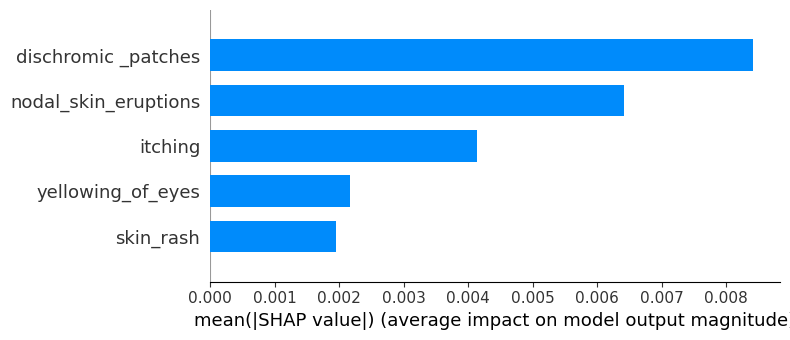


Feature importances for label: AIDS


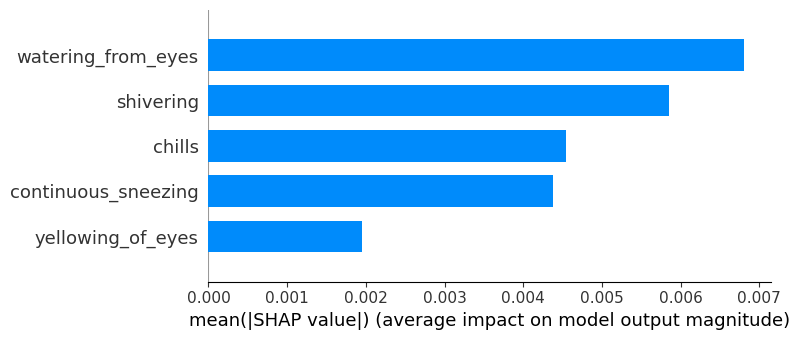


Feature importances for label: Acne


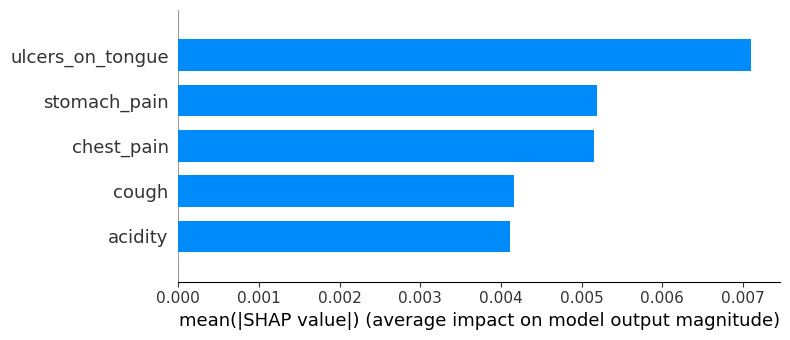


Feature importances for label: Alcoholic hepatitis


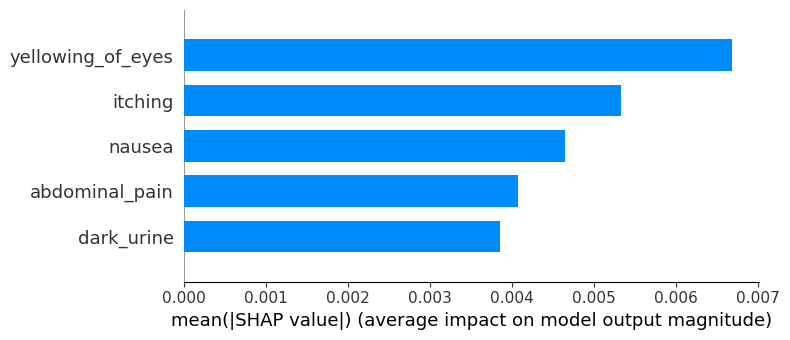


Feature importances for label: Allergy


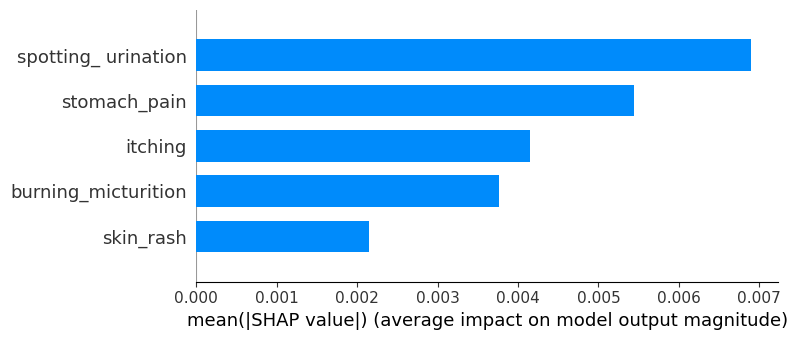


Feature importances for label: Arthritis


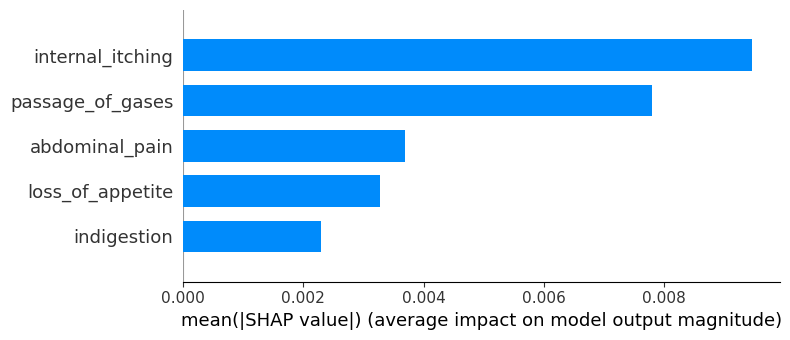


Feature importances for label: Bronchial Asthma


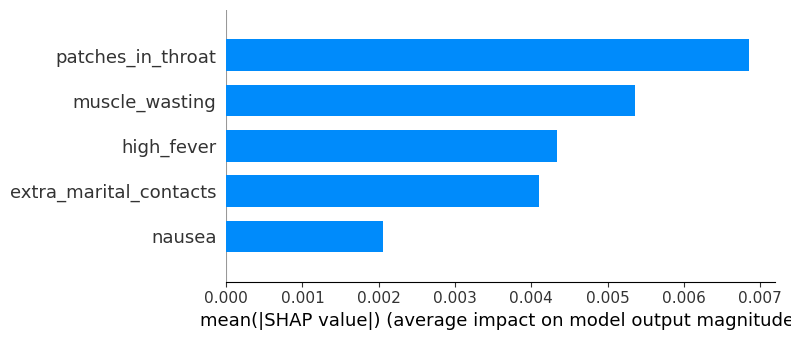


Feature importances for label: Cervical spondylosis


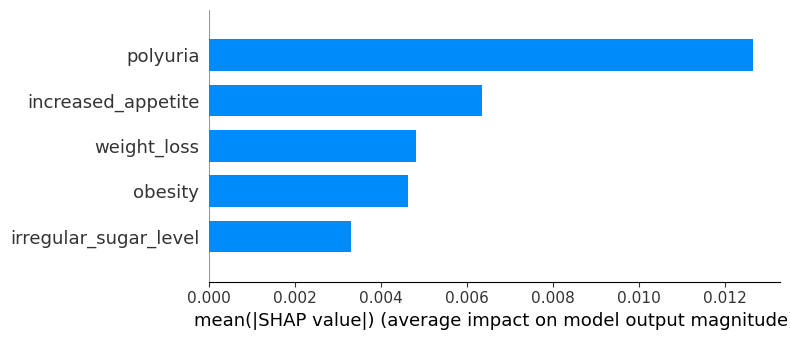


Feature importances for label: Chicken pox


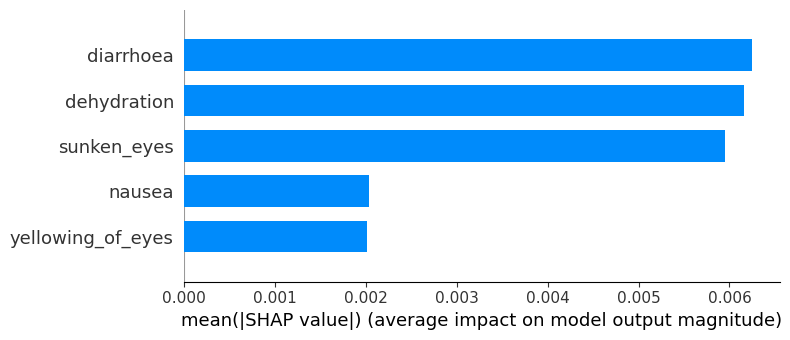


Feature importances for label: Chronic cholestasis


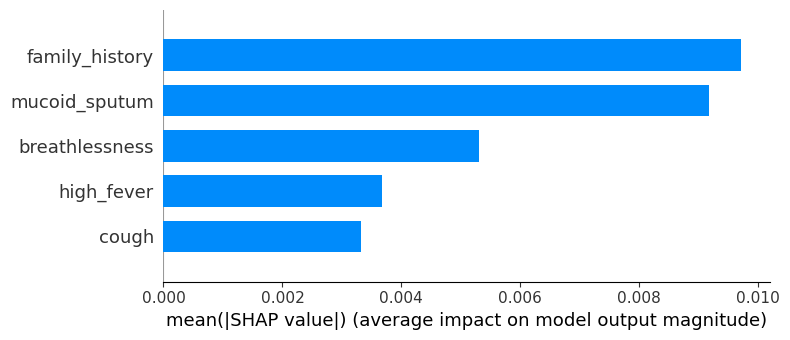


Feature importances for label: Common Cold


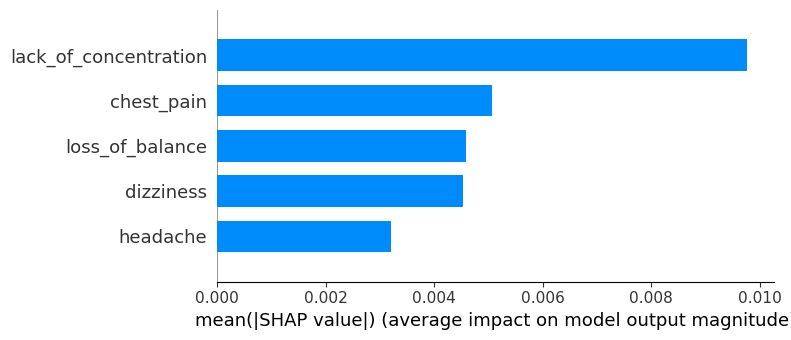


Feature importances for label: Dengue


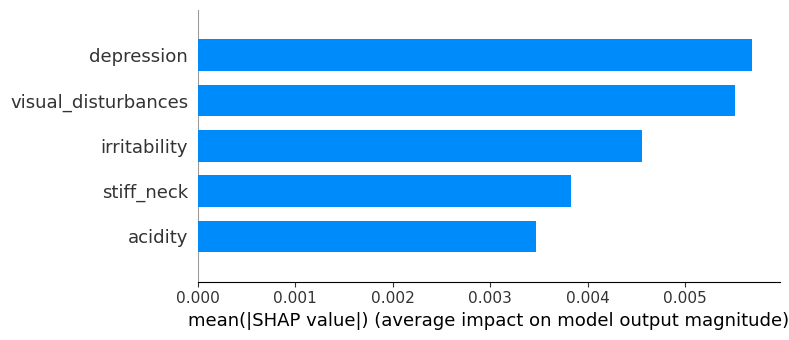


Feature importances for label: Diabetes 


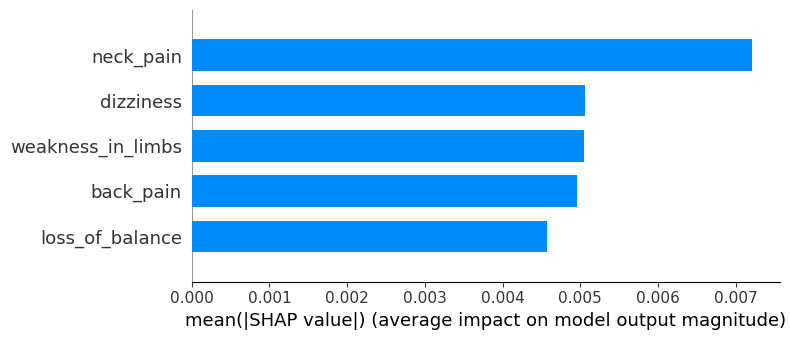


Feature importances for label: Dimorphic hemmorhoids(piles)


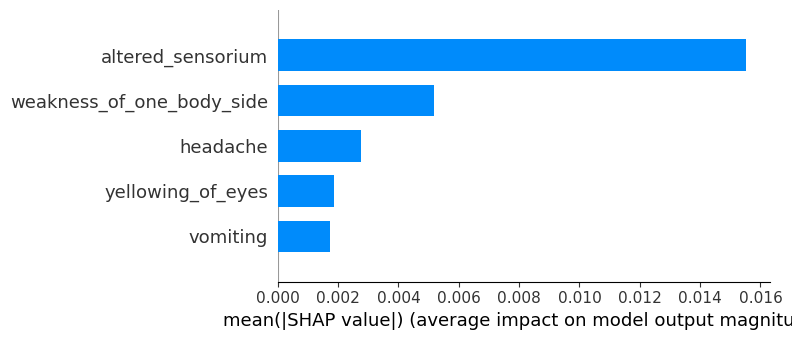


Feature importances for label: Drug Reaction


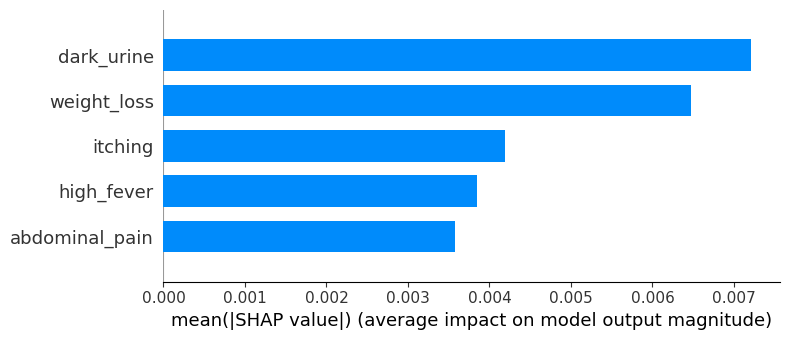


Feature importances for label: Fungal infection


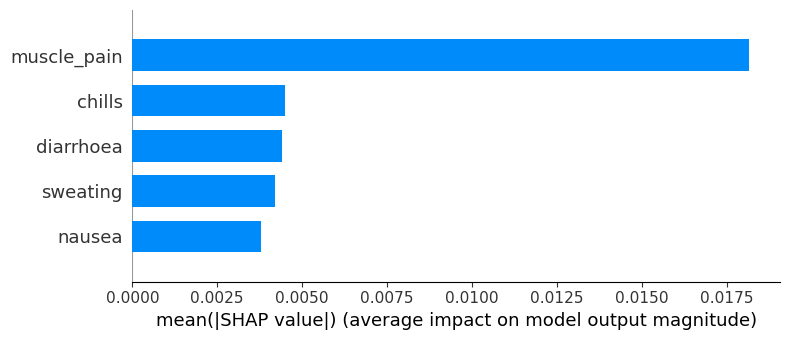


Feature importances for label: GERD


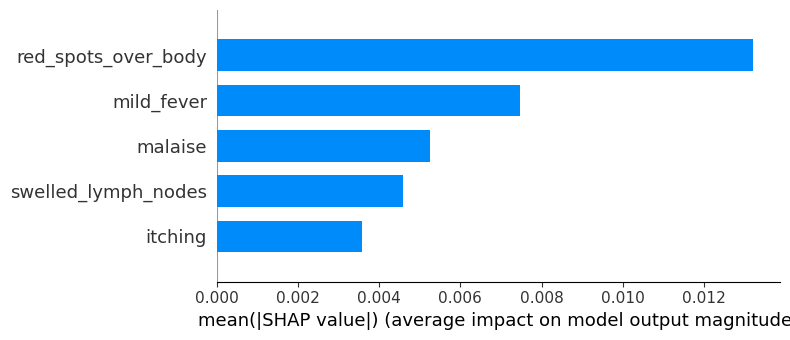


Feature importances for label: Gastroenteritis


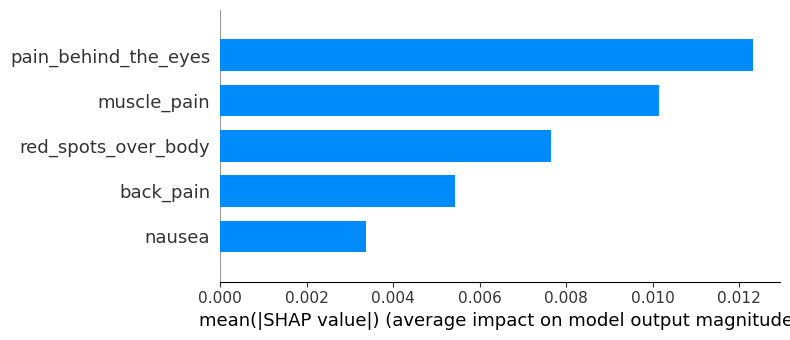


Feature importances for label: Heart attack


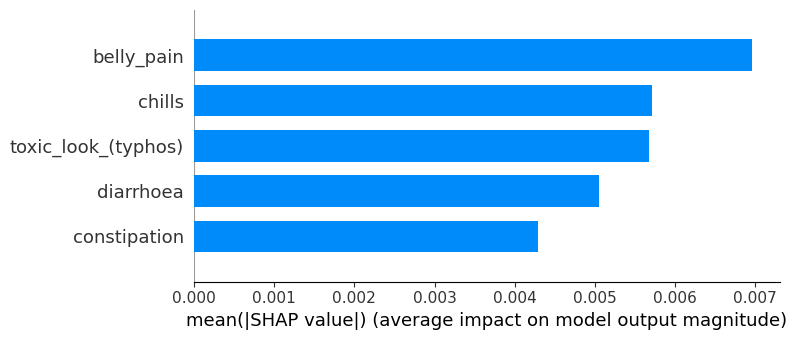


Feature importances for label: Hepatitis B


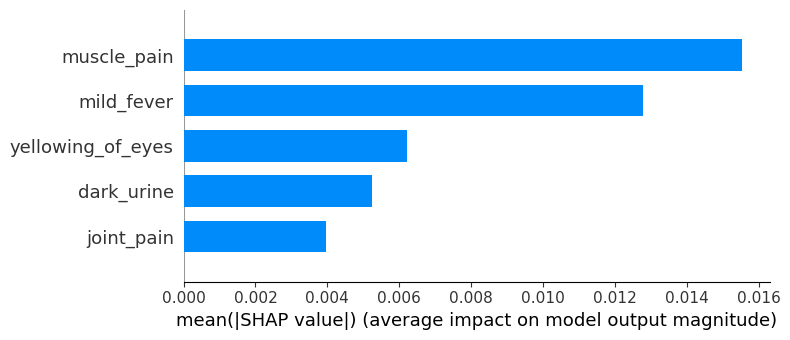


Feature importances for label: Hepatitis C


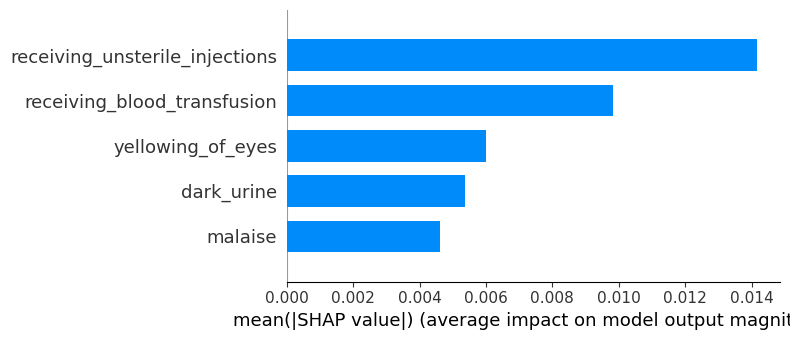


Feature importances for label: Hepatitis D


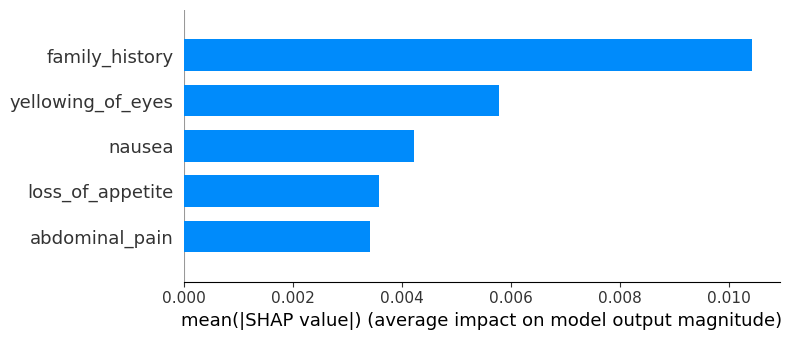


Feature importances for label: Hepatitis E


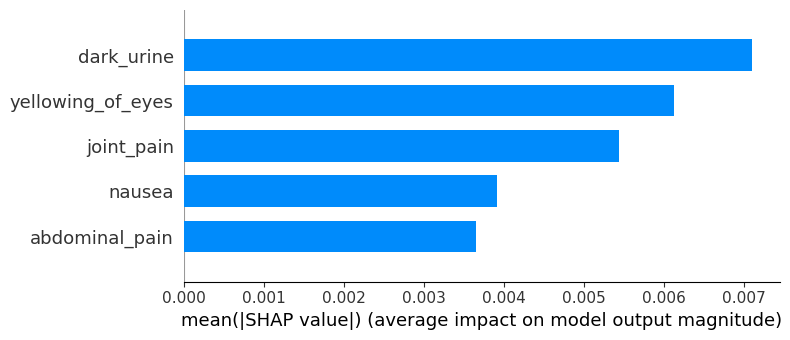


Feature importances for label: Hypertension 


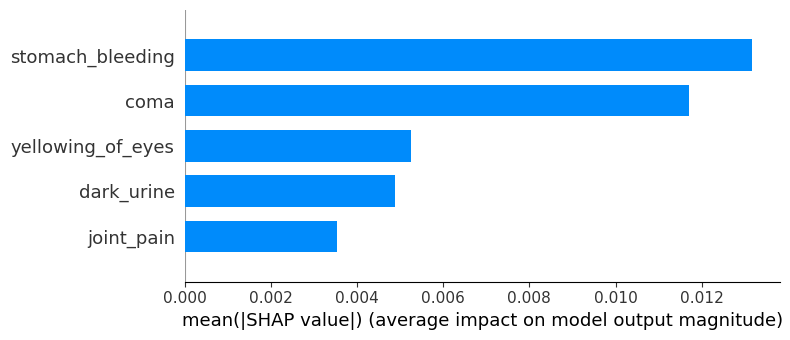


Feature importances for label: Hyperthyroidism


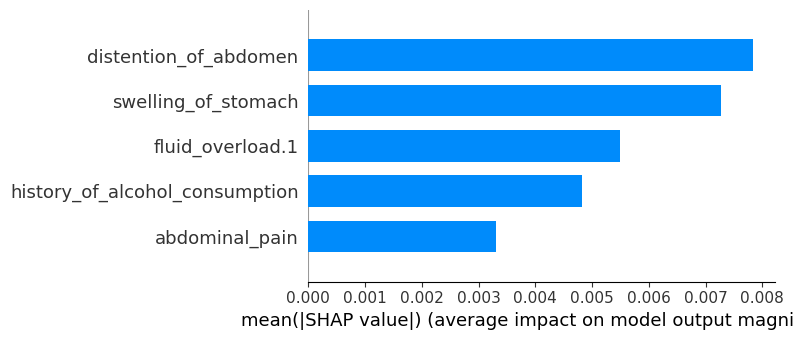


Feature importances for label: Hypoglycemia


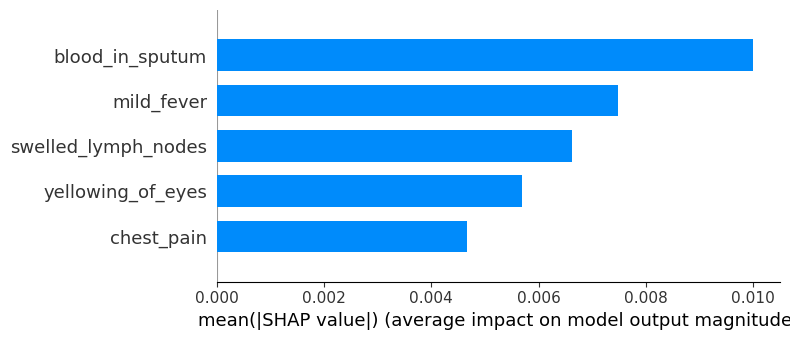


Feature importances for label: Hypothyroidism


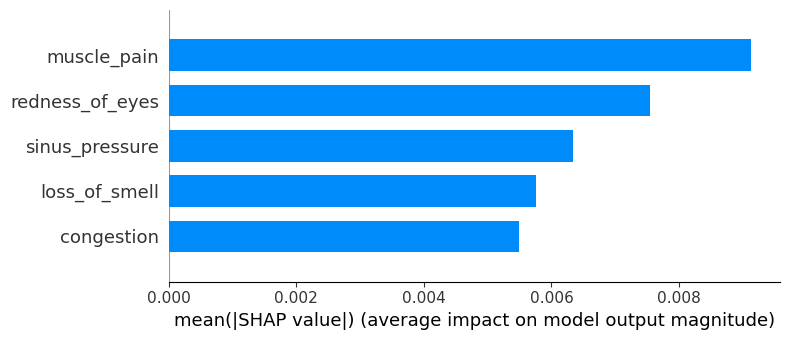


Feature importances for label: Impetigo


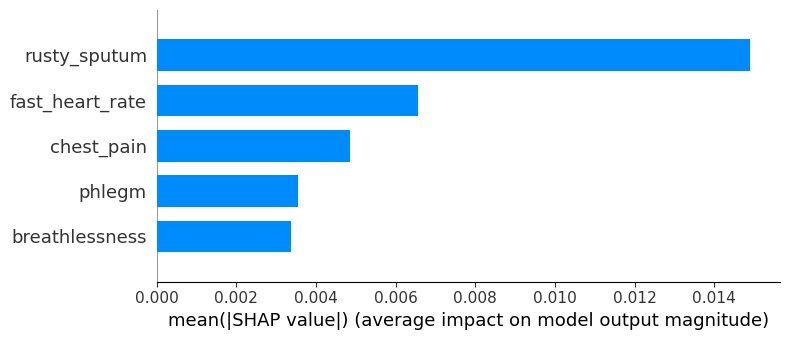


Feature importances for label: Jaundice


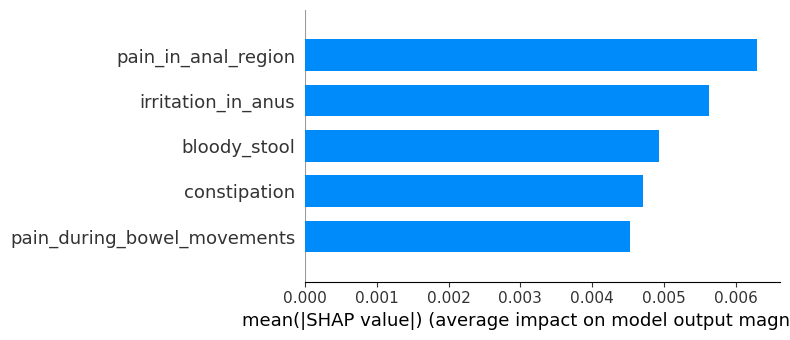


Feature importances for label: Malaria


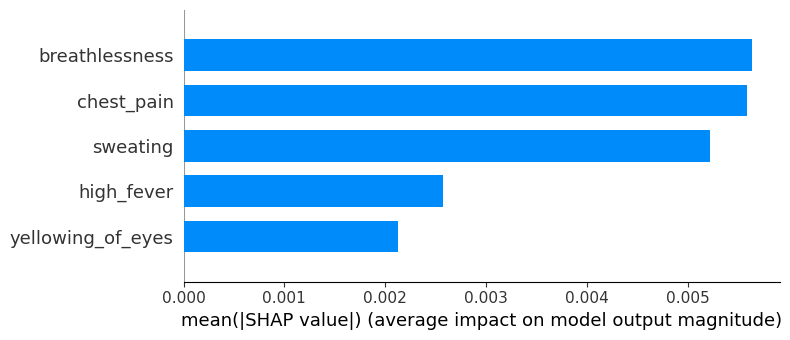


Feature importances for label: Migraine


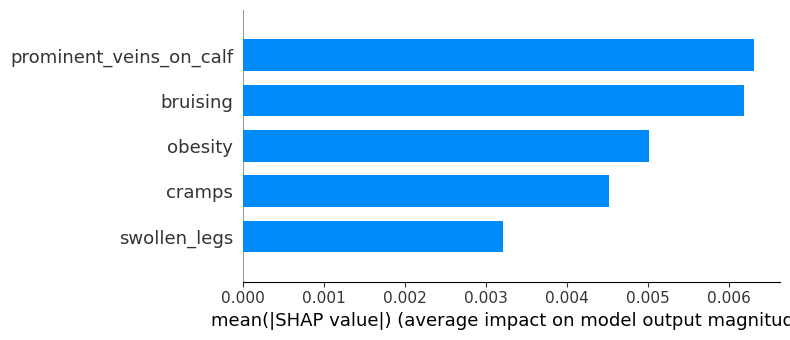


Feature importances for label: Osteoarthristis


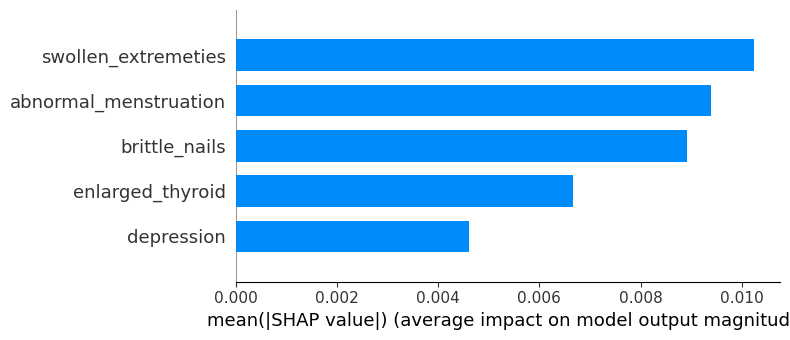


Feature importances for label: Paralysis (brain hemorrhage)


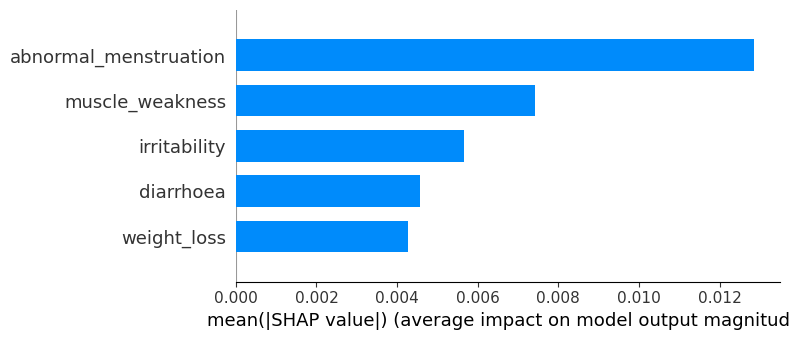


Feature importances for label: Peptic ulcer diseae


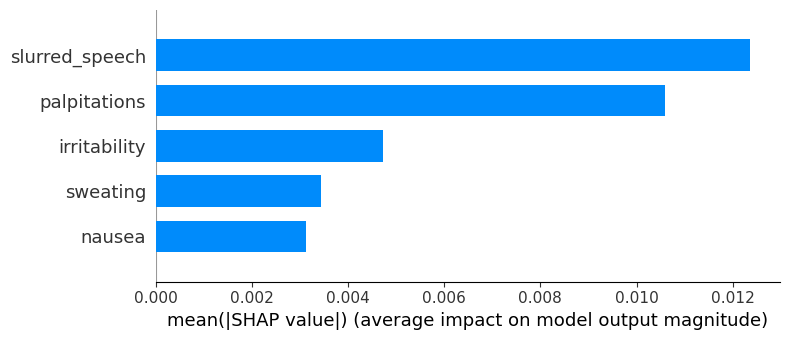


Feature importances for label: Pneumonia


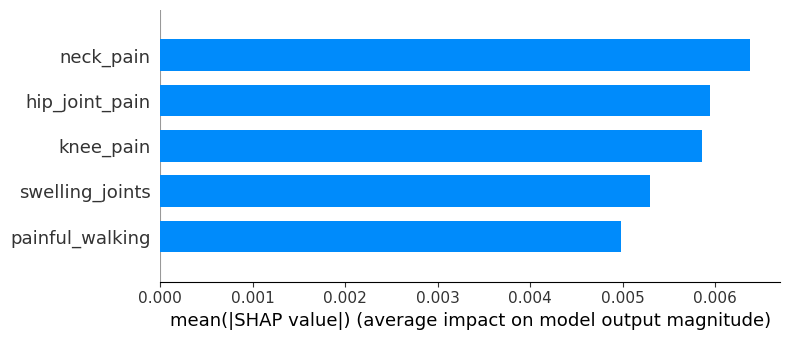


Feature importances for label: Psoriasis


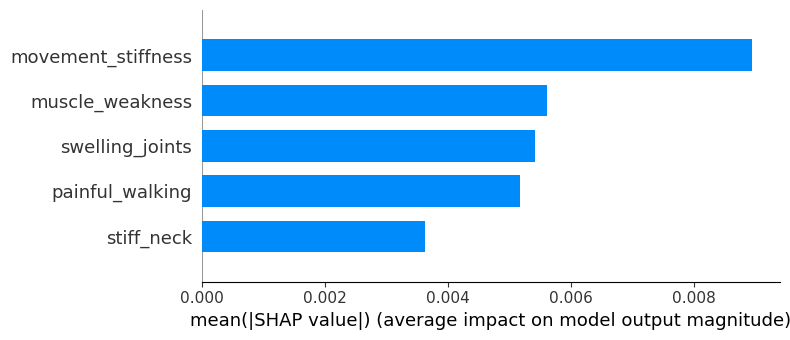


Feature importances for label: Tuberculosis


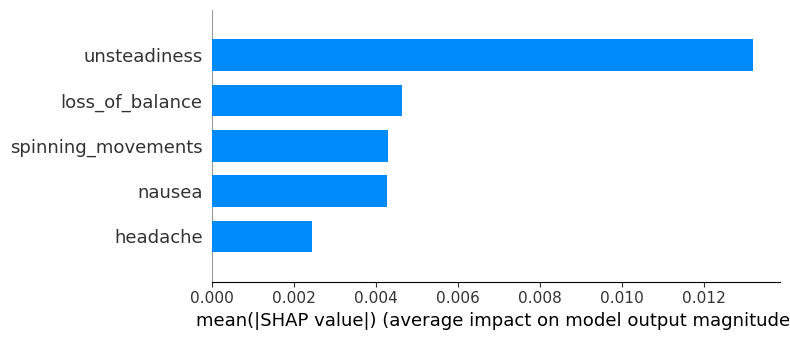


Feature importances for label: Typhoid


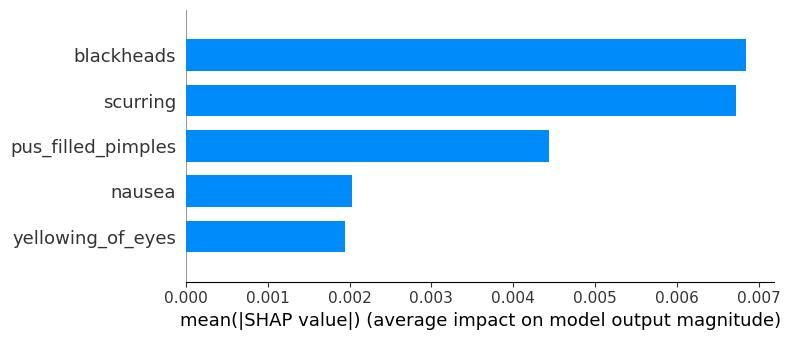


Feature importances for label: Urinary tract infection


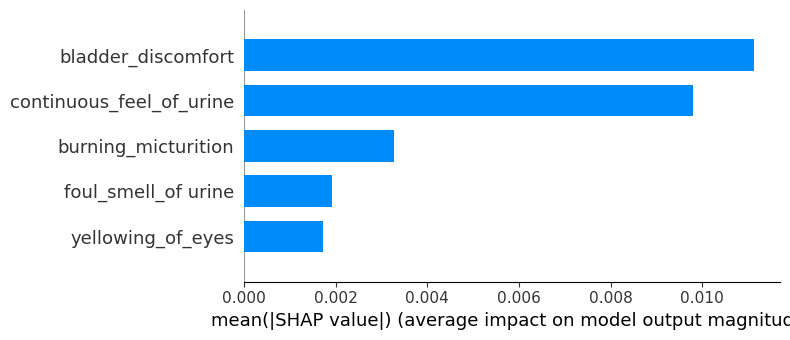


Feature importances for label: Varicose veins


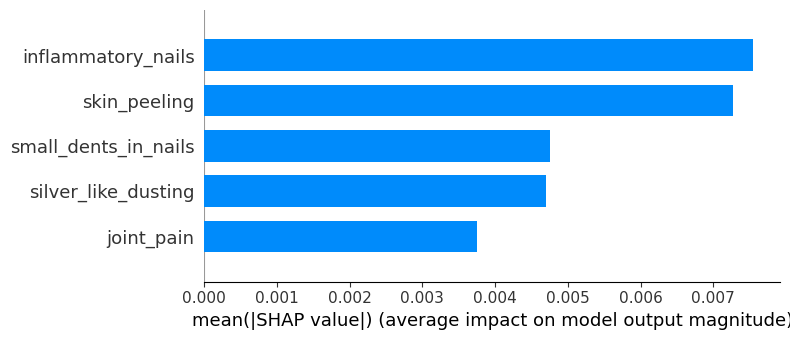


Feature importances for label: hepatitis A


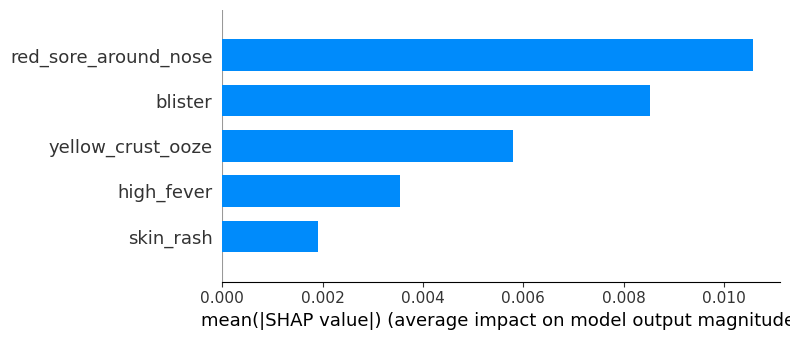

In [159]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import shap

# Assuming your dataset is loaded into a DataFrame `df`
# with 'target' as the column for prognosis and symptoms as feature columns

# Initialize and train the RandomForest model
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, Y_train)

# Use SHAP to explain the model's predictions
explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_test)

# Display feature importance for each class label
for i, class_name in enumerate(classifier.classes_):
    print(f"\nFeature importances for label: {class_name}")
    shap.summary_plot(shap_values[i].T, X_test, plot_type="bar", max_display=5)

# Optionally display summary plot for more detailed insights
#shap.summary_plot(shap_values, X_test)


In [35]:
print(f"Shape of shap_values[i]: {shap_values[i].shape}")
print(f"Shape of X_test: {X_test.shape}")


Shape of shap_values[i]: (132, 41)
Shape of X_test: (42, 132)


In [ ]:
preproc = ColumnTransformer(
    transformers=[
        ('num_transfoms', StandardScaler(), num_cols),

        ('cat_transforms', LabelEncoder(handle_unknown='ignore'), cat_cols)

        
le = LabelEncoder()
y_encoded = le.fit_transform(y)
    ], remainder='drop'
)

In [ ]:
pipeline_main = Pipeline([
    ('preprocessing', preproc),
    ('Regressor', DecisionTreeRegressor())
])
pipeline_A

In [ ]:
preproc2 = ColumnTransformer(
    transformers=[
        ('num_transforms', StandardScaler(), num_cols), 
        ('power_transforms', PowerTransformer(), selected_power_transform_cols),
        ('cat_transforms', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ], remainder='drop'
)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import LabelEncoder

class DropUnnamedColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Drop unnamed columns in X
        return X.loc[:, ~X.columns.str.contains('^Unnamed')]

# Then, include this transformer in your pipeline
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('drop_unnamed', DropUnnamedColumns()),
    # other pipeline steps...
])

processed_data = pipeline.fit_transform(train_data)


In [ ]:
X_train = train_data.drop(columns=['prognosis'])

Y_train = train_data['prognosis']

X_test = test_data.drop(columns=['prognosis'])

Y_test = test_data['prognosis']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

# Use a Random Forest Classifier in a multi-label setting
classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
classifier.fit(X_train, Y_train)

In [ ]:
# Sample data (replace with your actual dataset)
# features = pd.DataFrame(...)  # Replace with your symptoms data
# target = pd.DataFrame(...)    # Replace with your prognosis data (multilabel target)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Use a Random Forest Classifier in a multi-label setting
clf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Get feature importances for each label
feature_importances = {}
for i, label in enumerate(target.columns):
    # Extract feature importances for the current label
    importances = clf.estimators_[i].feature_importances_
    feature_importances[label] = importances

# Convert feature importances to a DataFrame
importances_df = pd.DataFrame(feature_importances, index=features.columns)
print("Feature Importances for Each Label:")
print(importances_df)

# Display top features for each label
top_features_per_label = {}
for label in target.columns:
    top_features_per_label[label] = importances_df[label].sort_values(ascending=False).head(5)
    print(f"Top features for {label}:")
    print(top_features_per_label[label], "\n")
